## Predicciones en el Mercado Inmobiliario de Dinamarca

#### 1. Análisis exploratorio de los datos analizando las diferentes regiones, precios, tamaños, características, tipos... a lo largo de los años.

#### 2. Predicciones sobre las futuras ventas de casas, precios según las regiones, tamaños, tipos de casa predominante, clasificación, ventas...

## 1. EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns
import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
#Cargar csv
df_houses = pd.read_csv('houses.csv')
#Filtro para solo años por encima de 1800
df_houses_year = df_houses[df_houses['year_build'] > 1800]

### Limpieza de datos

Limpiamos los datos del dataset, eliminando una de sus columnas que para nuestro proyecto no aporta gran valor, después analizamos si alguna columna está duplicada o si hay algún valor faltante en el conjunto de datos, viendo que nuestro dataset no tiene valores faltantes a exceppción de algunos datos de inflación y ciudades, pero un número insignificativo.

In [3]:
#Eliminar columnas sin interés
columns_to_drop = ['yield_on_mortgage_credit_bonds%']
df_houses = df_houses.drop(columns=columns_to_drop)

In [4]:
# Contar el número de filas duplicadas
num_duplicates = df_houses.duplicated().sum()
print(f"Número de filas duplicadas: {num_duplicates}")

Número de filas duplicadas: 0


In [5]:
# Encontrar filas duplicadas
filas_duplicadas = df_houses[df_houses.duplicated()]

In [6]:
def valores_faltantes(data):
  total = data.isnull().sum()
  porcentaje = (data.isnull().sum()/data.isnull().count()*100)
  tt = pd.concat([total, porcentaje], axis=1, keys=['Total', 'Porcentaje'])
  types = []
  for col in data.columns:
    dtype = str(data[col].dtype)
    types.append(dtype)
  tt['Tipos'] = types
  return np.transpose(tt)

valores_faltantes(df_houses)

date quarter house_id house_type sales_type year_build  \
Total            0       0        0          0          0          0   
Porcentaje     0.0     0.0      0.0        0.0        0.0        0.0   
Tipos       object  object    int64     object     object      int64   

           purchase_price %_change_between_offer_and_purchase no_rooms  \
Total                   0                                   0        0   
Porcentaje            0.0                                 0.0      0.0   
Tipos               int64                             float64    int64   

                sqm sqm_price address zip_code    city    area  region  \
Total             0         0       0        0      11       0       0   
Porcentaje      0.0       0.0     0.0      0.0   0.011     0.0     0.0   
Tipos       float64   float64  object    int64  object  object  object   

           nom_interest_rate% dk_ann_infl_rate%  
Total                       0                77  
Porcentaje                0.0             0.077  
Tipos                 float64           float64

In [7]:
df_houses['city'].unique()

array(['Solrød Strand', 'Frederiksberg C', 'Kalundborg', 'Farum',
       'Svendborg', 'Skovlunde', 'Erslev', 'Branderup J', 'Holsted',
       'Esbjerg', 'Jægerspris', 'Silkeborg', 'Snertinge', 'Agedrup',
       'Hornbæk', 'Sønderborg', 'Aabenraa', 'Fredericia', 'Roskilde',
       'Alsted', 'Aarhus C', 'Odense C', 'Ikast', 'Aars', 'Barrit',
       'Faxe', 'Sjællands Odde', 'Hurup Thy', 'Valby', 'Humlebæk',
       'Slagelse', 'Vig', 'Charlottenlund', 'Greve', 'Odense N',
       'Store Fuglede', 'Ringsted', 'Idestrup', 'Skødstrup',
       'Nykøbing Sj', 'København N', 'Karby', 'Faaborg', 'Ã\x85lsgårde',
       'Lemvig', 'Ansager', 'Gjerlev J', 'Hørsholm', 'Assens',
       'Vordingborg', 'Aulum', 'Ebeltoft', 'Bogense', 'Løgstrup',
       'Glostrup', 'Skive', 'Fuglebjerg', 'Astbirk', 'Rødekro', 'Malling',
       'Randers NV', 'Ringkøbing', 'Herning', 'Arbæk', 'Brovst', 'Søborg',
       'Fanø', 'Gentofte', 'Hedehusene', 'Aalborg', 'Tarm', 'Sunds',
       'Helsinge', 'Mørkøv', 'Nexø', 'Højsle

### Observar datos

Observamos algunos de los datos del dataset, viendo las columnas que tenemos disponibles sobre las diferentes construcciones y su información

In [8]:
df_houses_year = df_houses[df_houses['year_build'] > 1800]
df_houses.head()

date quarter  house_id house_type    sales_type  year_build  \
0  2024-10-24  2024Q4        16      Villa  regular_sale        1997   
1  2024-10-24  2024Q4        13  Apartment  regular_sale        1885   
2  2024-10-23  2024Q4        60      Villa  regular_sale        1949   
3  2024-10-23  2024Q4        29      Villa  regular_sale        2001   
4  2024-10-22  2024Q4        92  Apartment  regular_sale        1965   

   purchase_price  %_change_between_offer_and_purchase  no_rooms    sqm  \
0         6500000                                 -3.0         5  142.0   
1         3400000                                  0.0         2   46.0   
2         4550000                                 -4.0         4  112.0   
3         1630000                                -12.0         4  186.0   
4         1975000                                -10.0         3   82.0   

   sqm_price                          address  zip_code             city  \
0  45774.650                     Spættevej 16      2680    Solrød Strand   
1  73913.050  Jakob Dannefærds Vej 10B, 4. th      1973  Frederiksberg C   
2  40625.000             Vestre Plantagevej 3      2680    Solrød Strand   
3   8763.440                     Toftebjerg 3      4400       Kalundborg   
4  24085.365        Ryttergårdsvej 20, 1. 113      3520            Farum   

                  area   region  nom_interest_rate%  dk_ann_infl_rate%  
0  Capital, Copenhagen  Zealand                 3.1                NaN  
1  Capital, Copenhagen  Zealand                 3.1                NaN  
2  Capital, Copenhagen  Zealand                 3.1                NaN  
3        Other islands  Zealand                 3.1                NaN  
4        North Zealand  Zealand                 3.1                NaN

Apreciamos las variables cuantitativas y cualitativas del conjunto de datos para poder realizar el análisis de manera adecuada.

In [9]:
print(df_houses.index)
print(df_houses.shape)
df_houses.info()

RangeIndex(start=0, stop=100000, step=1)
(100000, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   date                                 100000 non-null  object 
 1   quarter                              100000 non-null  object 
 2   house_id                             100000 non-null  int64  
 3   house_type                           100000 non-null  object 
 4   sales_type                           100000 non-null  object 
 5   year_build                           100000 non-null  int64  
 6   purchase_price                       100000 non-null  int64  
 7   %_change_between_offer_and_purchase  100000 non-null  float64
 8   no_rooms                             100000 non-null  int64  
 9   sqm                                  100000 non-null  float64
 10  sqm_price                  

En cuanto a datos estadísticos podemos ver que la media de año de construcción es de 1955, la de número de habitaciones es 4.3, la diferencia de oferta y venta es de -2€, de 128m2, de 16406€ el m2 y de los valores macroeconómicos como el interés y la inflación 1.6% y 1.9% respectivamente.
También apreciamos que entre los valores máximos y mínimos encontramos -49% y 49% en la diferencia de oferta y venta, 1 y 15 en el número de habitaciones, 26 y 984m2 en sqm, 374 y 75000€ el m2 y en cuanto a los valores macroeconómicos, en interés 0 y 9.5 e inflación 0.25 y 7.7

In [10]:
df_houses.describe()

house_id     year_build  purchase_price  \
count  1.000000e+05  100000.000000    1.000000e+05   
mean   7.531364e+05    1955.078530    1.925992e+06   
std    4.348902e+05      45.703585    1.777832e+06   
min    1.300000e+01    1000.000000    2.502000e+05   
25%    3.770722e+05    1931.000000    8.000000e+05   
50%    7.511035e+05    1966.000000    1.400000e+06   
75%    1.128904e+06    1980.000000    2.450000e+06   
max    1.507901e+06    2024.000000    4.595500e+07   

       %_change_between_offer_and_purchase       no_rooms            sqm  \
count                        100000.000000  100000.000000  100000.000000   
mean                             -2.084740       4.375790     129.387820   
std                               4.852926       1.661686      57.170619   
min                             -49.000000       1.000000      26.000000   
25%                              -3.000000       3.000000      89.000000   
50%                               0.000000       4.000000     123.000000   
75%                               0.000000       5.000000     160.000000   
max                              49.000000      15.000000     984.000000   

           sqm_price       zip_code  nom_interest_rate%  dk_ann_infl_rate%  
count  100000.000000  100000.000000       100000.000000       99923.000000  
mean    16406.648074    5951.612680            1.679263           1.927025  
std     13655.184405    2369.938171            2.048078           1.638440  
min       374.549800    1051.000000            0.000000           0.250000  
25%      6792.940775    4000.000000            0.000000           0.790000  
50%     12070.707000    5970.000000            0.750000           1.850000  
75%     21343.201500    8250.000000            3.250000           2.340000  
max     75000.000000    9990.000000            9.500000           7.700000

En los datos estadísticos de las variables cualitativas, apreciamos la mayoría de construcciones son villas, se han vendido por venta regular, son de Jutland del area sur, en concreto de la ciudad de Copenague, es decir, la capital y la mayoría son de la calle Vibejev. También vemos que el punto mayor de ventas fue en el primer cuatrimestre de 2021.

In [11]:
df_houses.describe(include='object')

date quarter house_type    sales_type    address         city  \
count       100000  100000     100000        100000     100000        99989   
unique       11254     130          5             4      92463          607   
top     2023-12-19  2021Q1      Villa  regular_sale  Vibevej 2  København S   
freq            49    2263      54214         88232         12         1275   

                 area   region  
count          100000   100000  
unique              8        4  
top     South jutland  Jutland  
freq            22563    49937

### Análisis Univariante

Para comenzar, vamos a realizar un análisis univariante de las distintas variables recogidas en el dataset, en el primer gráfico podemos ver que el cuatrimestre donde más ventas hubo fue en el primer cuatrimestre de 2021, seguido del segundo de 2021.
En cuanto a tipos de casa predomina con bastante diferencia las villas, habiendo muy pocas construcciones de granjas, seguidamente podemos ver que lo más común son ventas normales, seguido de ventas familiares y los casos más raros son de subastas.
Por otro lado, podemos ver los años de las construcciones donde apreciamos una subida hasta el pico en torno a 1980 y después una leve bajada de construcciones.
Sobre los precios, vemos que la mayoría se encuentran por de bajo de 10 millones, estando la mayoría entre 1 y 6 millones de euros, y de esos precios, el cambio entre la oferta y el precio de la venta, podemos ver que no suele variar mucho con valores entre -10 y 4 de variación. 
Aquí podemos ver diferentes características de las casas, donde destacamos que predominan las casas con 4 habitaciones, de 100m2 y de menos de 5000€/m2
En cuanto a las zonas de las diferentes construcciones, la mayoría se encuentran en la región de jutland, en concreto en el area sur de la región y sin sorpresas, podemos ver que la ciudad que más destaca es Copenague, habiendo menos casas en la región de Bornholm.
Finalmente, en cuanto a datos económicos lo más común es el ratio de interés por debajo de 1% y el porcentaje de inflación por debajo del 3%.

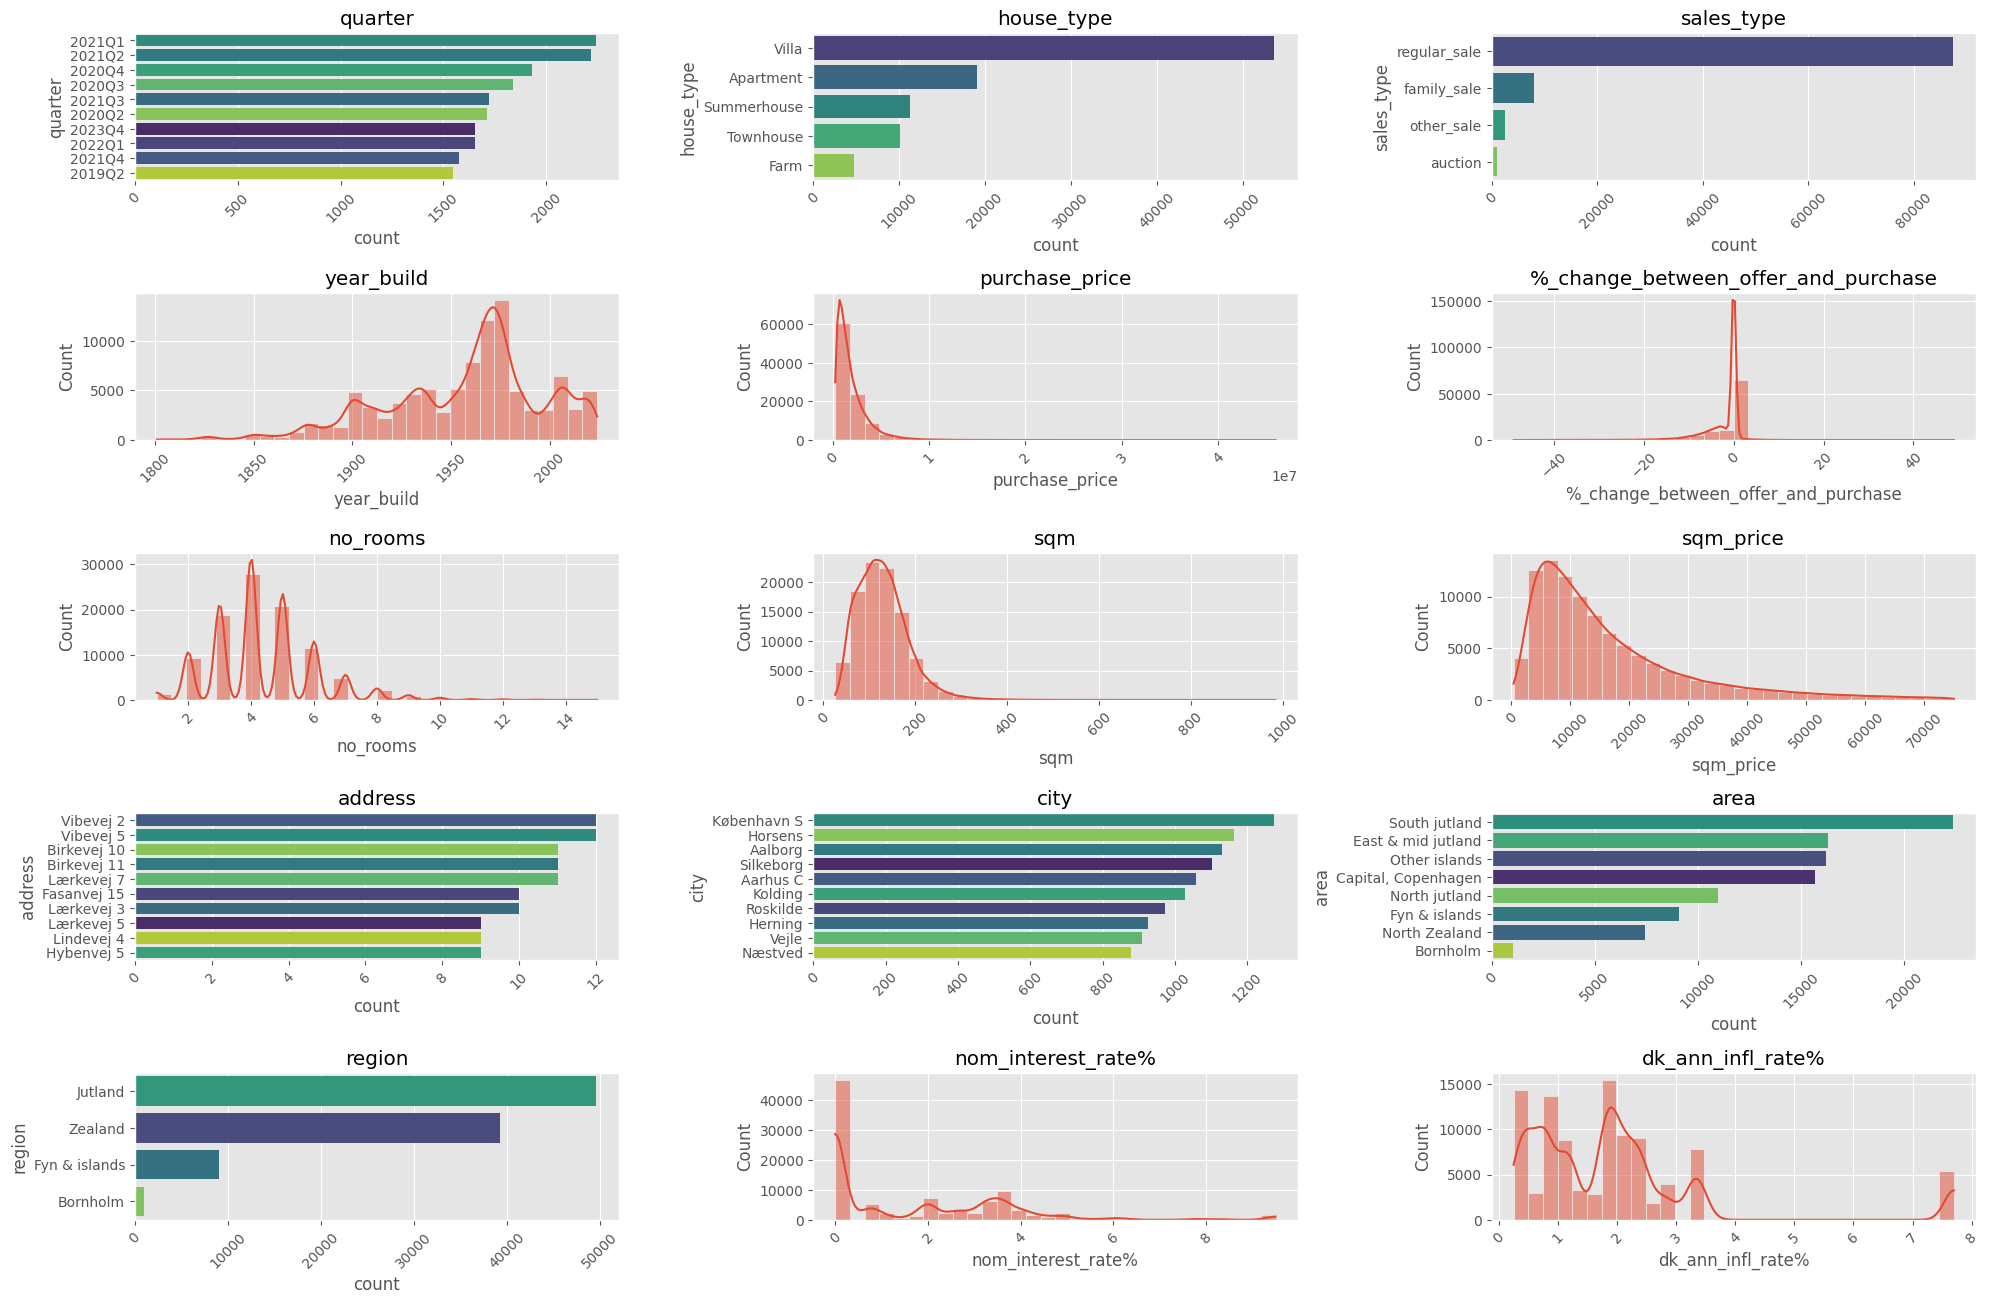

In [12]:
import math

# Análisis univariante
def analisis_univariante(data, cols=3, width=20, height=15):
    # Crear una figura con el tamaño definido por los parámetros width y height
    fig = plt.figure(figsize=(width, height))

    # Calcular el número de filas necesarias para acomodar todas las columnas en la gráfica
    rows = math.ceil(data.shape[1] / cols)

    # Contador para los subplots
    plot_index = 1

    # Iterar sobre cada columna en el dataset
    for column in data.columns:
        if column in ['house_id', 'date','zip_code']:
            continue  # Omitir las columnas especificadas

        # Crear subplots, añadiendo cada uno en su posición dentro de la cuadrícula de filas y columnas
        ax = fig.add_subplot(rows, cols, plot_index)
        plot_index += 1

        # Establecer el título de cada subplot como el nombre de la columna actual
        ax.set_title(column)

        if data[column].dtype == 'object':
            # Limitar el número de categorías a mostrar
            top_categories = data[column].value_counts().index[:10]
            sns.countplot(data=data[data[column].isin(top_categories)], y=column, ax=ax, palette='viridis', order=top_categories, hue=column, legend=False)
            plt.xticks(rotation=45)
        else:
            # Usar un histograma con KDE para columnas numéricas, limitando el número de bins
            sns.histplot(data[column], ax=ax, kde=True, bins=30)
            plt.xticks(rotation=45)

    # Ajustar el layout de la figura para evitar solapamientos entre subplots
    plt.tight_layout()
    plt.show()

analisis_univariante(df_houses_year)

### Sesgo

1. house_id (0.004244) → Casi 0, lo que indica una distribución simétrica.
2. year_build (-2.449721) → Sesgo negativo fuerte, lo que sugiere que la mayoría de los valores son altos y hay pocos valores bajos. Probablemente hay muchas casas modernas y pocas casas antiguas.
3. purchase_price (3.434825) → Sesgo positivo fuerte, indicando que la mayoría de los precios de compra son bajos, pero hay algunos precios muy altos que estiran la cola derecha.
4. %_change_between_offer_and_purchase (-2.628064) → Sesgo negativo fuerte, lo que sugiere que la mayoría de los cambios entre oferta y compra son pequeños, pero hay algunas reducciones grandes.
5. no_rooms (0.913627) → Sesgo positivo moderado, lo que indica que la mayoría de las casas tienen pocas habitaciones, pero algunas tienen muchas.
6. sqm (1.696632) → Sesgo positivo significativo, lo que indica que la mayoría de las casas tienen pocos metros cuadrados, pero hay algunas mucho más grandes.
7. sqm_price (1.674143) → Sesgo positivo moderado, lo que sugiere que la mayoría de las propiedades tienen un precio por metro cuadrado bajo, pero algunas tienen precios significativamente más altos.
8. zip_code (-0.013770) → Muy cercano a 0, indicando una distribución aproximadamente simétrica.
9. nom_interest_rate% (1.350773) → Sesgo positivo moderado, lo que sugiere que la mayoría de las tasas de interés nominales son bajas, pero algunas son más altas.
10. dk_ann_infl_rate% (2.243389) → Sesgo positivo fuerte, indicando que la mayoría de las tasas de inflación anual son bajas, pero hay algunos valores muy altos.

In [13]:
# Calcular la asimetría y la curtosis de las variables numéricas
sesgo = df_houses.select_dtypes(include=['float64', 'int64']).skew()
curtosis = df_houses.select_dtypes(include=['float64', 'int64']).kurt()

# Crear un dataframe con los resultados
sesgo_curtosis = pd.DataFrame({'Sesgo': sesgo, 'Curtosis': curtosis})

print(sesgo_curtosis)

                                        Sesgo   Curtosis
house_id                             0.004244  -1.197434
year_build                          -2.449721  28.856312
purchase_price                       3.434825  25.456699
%_change_between_offer_and_purchase -2.628064  18.915827
no_rooms                             0.913627   2.271718
sqm                                  1.696632  10.454610
sqm_price                            1.674143   2.841695
zip_code                            -0.013770  -1.268616
nom_interest_rate%                   1.350773   2.179242
dk_ann_infl_rate%                    2.243389   5.604241


### Comparar precios a lo largo del tiempo según tipo de casa

Si ahora evaluamos los precios según los tipos de casa, podemos ver que siempre ha prevalecido la granja con precios más altos, aunque actualmente los apartamentos están superando a los demás, las casas de verano se han mantenido las más bajas excepto en la década de 1910, en cuanto a las villas se han mantenido constantes en torno a 1 millón y las casas de pueblo están experimentando actualmente una subida aunque menor que las granjas.

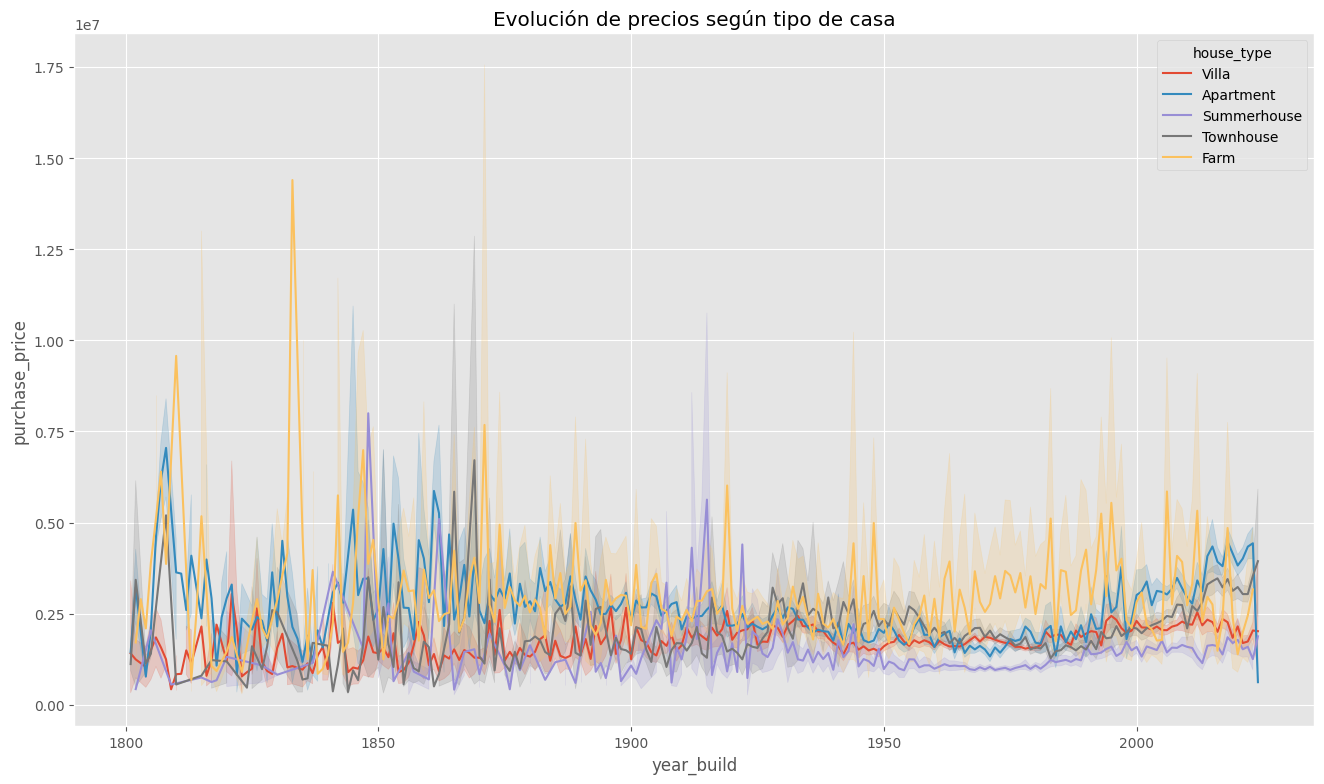

In [14]:
#Gráfico de evolución de precios según house_type
sns.lineplot(x='year_build', y='purchase_price', data=df_houses_year, hue='house_type')
plt.title('Evolución de precios según tipo de casa')
plt.show()

### Comparar los precios según región a lo largo del tiempo

Ahora vamos a hablar de los precios según la región, donde podemos ver que siempre se ha mantenido con precios más altos Zealand y los más bajos Bornholm aunque con algún pico en años recientes y en torno a 1830. 
Podemos apreciar que los precios vuelven a subir en torno a nuestros años, por encima de los 2.5M,

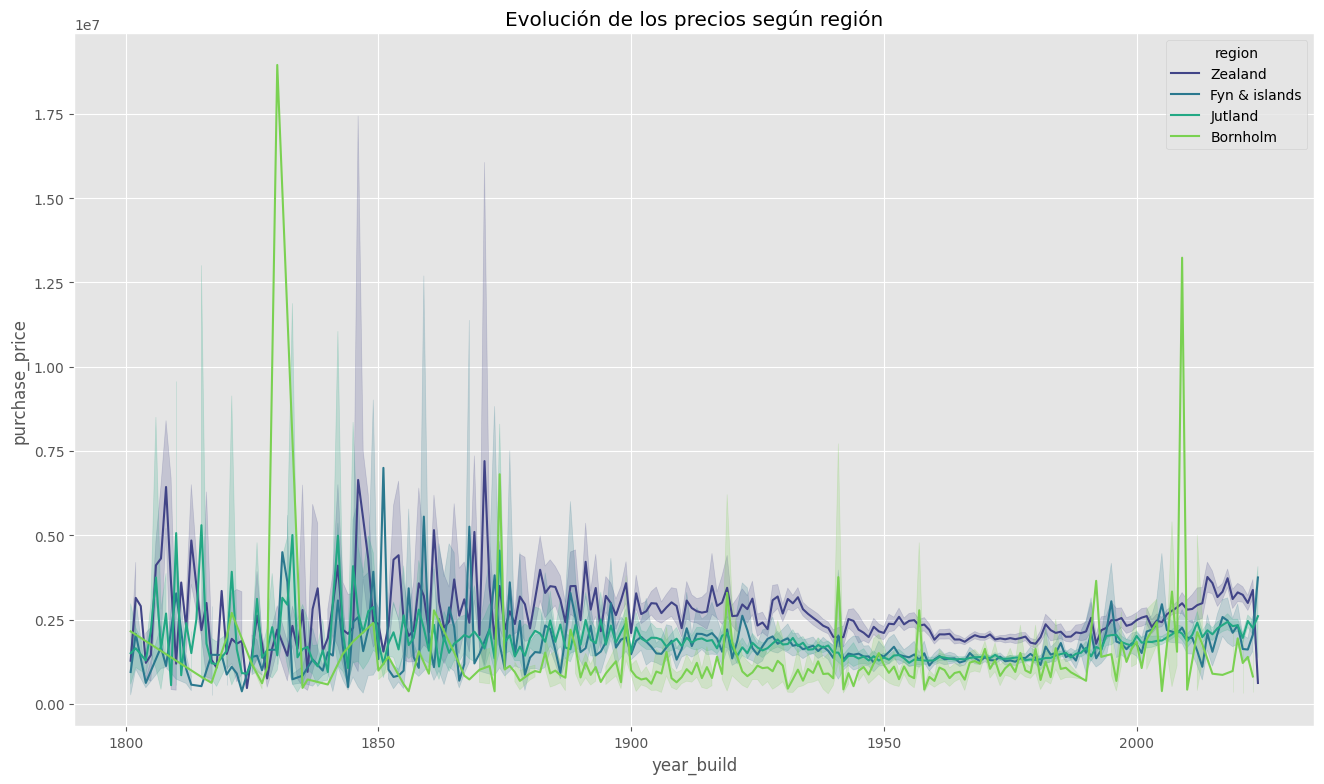

In [15]:
# Gráfico de la evolución de los precios según region
plt.figure(figsize=(16, 9))
sns.lineplot(x='year_build', y='purchase_price', data=df_houses_year, hue='region', palette='viridis')
plt.title('Evolución de los precios según región')
plt.show()

### Comparar tamaño y precio según región

Podemos apreciar que la mayor parte de la distribución de casas se encuenta por debajo de los 400m2 y por debajo de los 20000000€, también destacamos que las construcciones más grandes están en Zealand y tienen precios menores, en cuanto a los valores del gran conjunto se aprecia que a más metros cuadrados aumenta el precio.

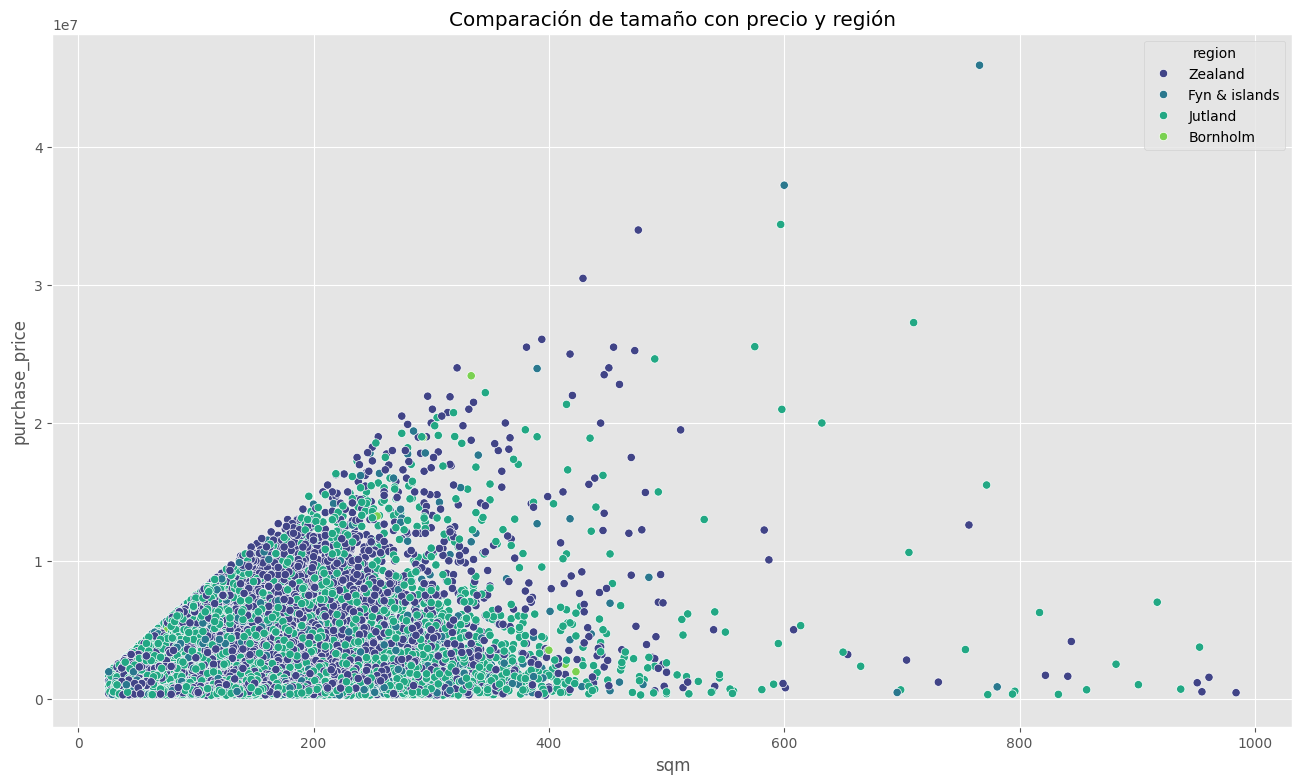

In [16]:
# Gráfico para comparar sqm con purchase_price y region
plt.figure(figsize=(16, 9))
sns.scatterplot(x='sqm', y='purchase_price', data=df_houses, hue='region', palette='viridis')
plt.title('Comparación de tamaño con precio y región')
plt.show()

### Comparar Precio y tamaño a lo largo de los años

Podemos apreciar que la mayoría de construcciones son de tamaños inferiores a 400m2, ya que predominan en el gráfico, destacamos que los pocos casos de más de 600m2 los encontramos en precios más elevados, en menor medida. Esta distribución se ha mantenido parecida a lo largo del tiempo.

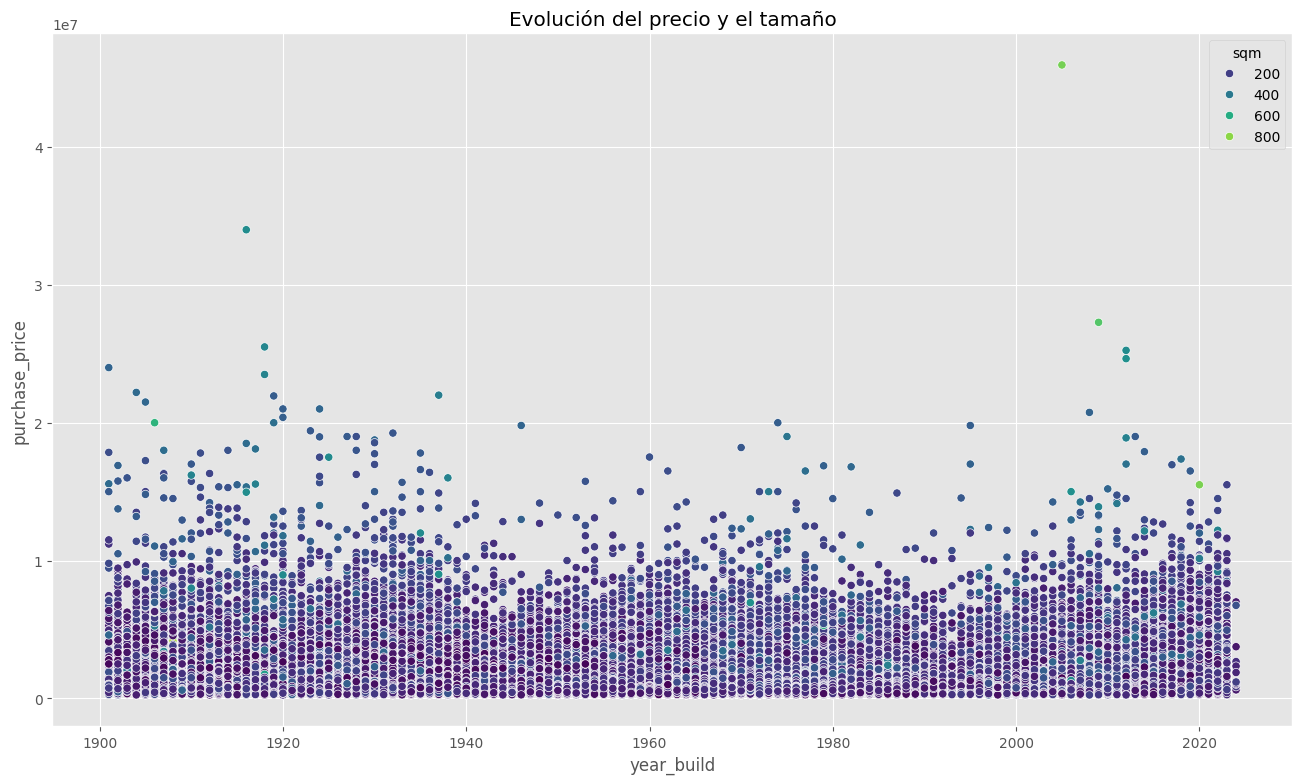

In [17]:
#Filtro para solo años por encima de 1900
df_houses_1900 = df_houses[df_houses['year_build'] > 1900]
#Gráfico para comparar year_build con purchase_price y sqm
plt.figure(figsize=(16, 9))
sns.scatterplot(x='year_build', y='purchase_price', data=df_houses_1900, hue='sqm', palette='viridis')
plt.title('Evolución del precio y el tamaño')
plt.show()

### Evolución de tipos de casa en cada región

A continuación vamos a analizar el número de casas según los tipos de casa, donde apreciamos que la mayoría de construcciones en todas las regiones son de villas, habiendo también un número importante de apartamentos en Zealand y lo que menos presencia hay son casas de verano, las cuales a excepción bronholm tuvieron un repunte en 1980. También se observa un repunte de casas en 1900

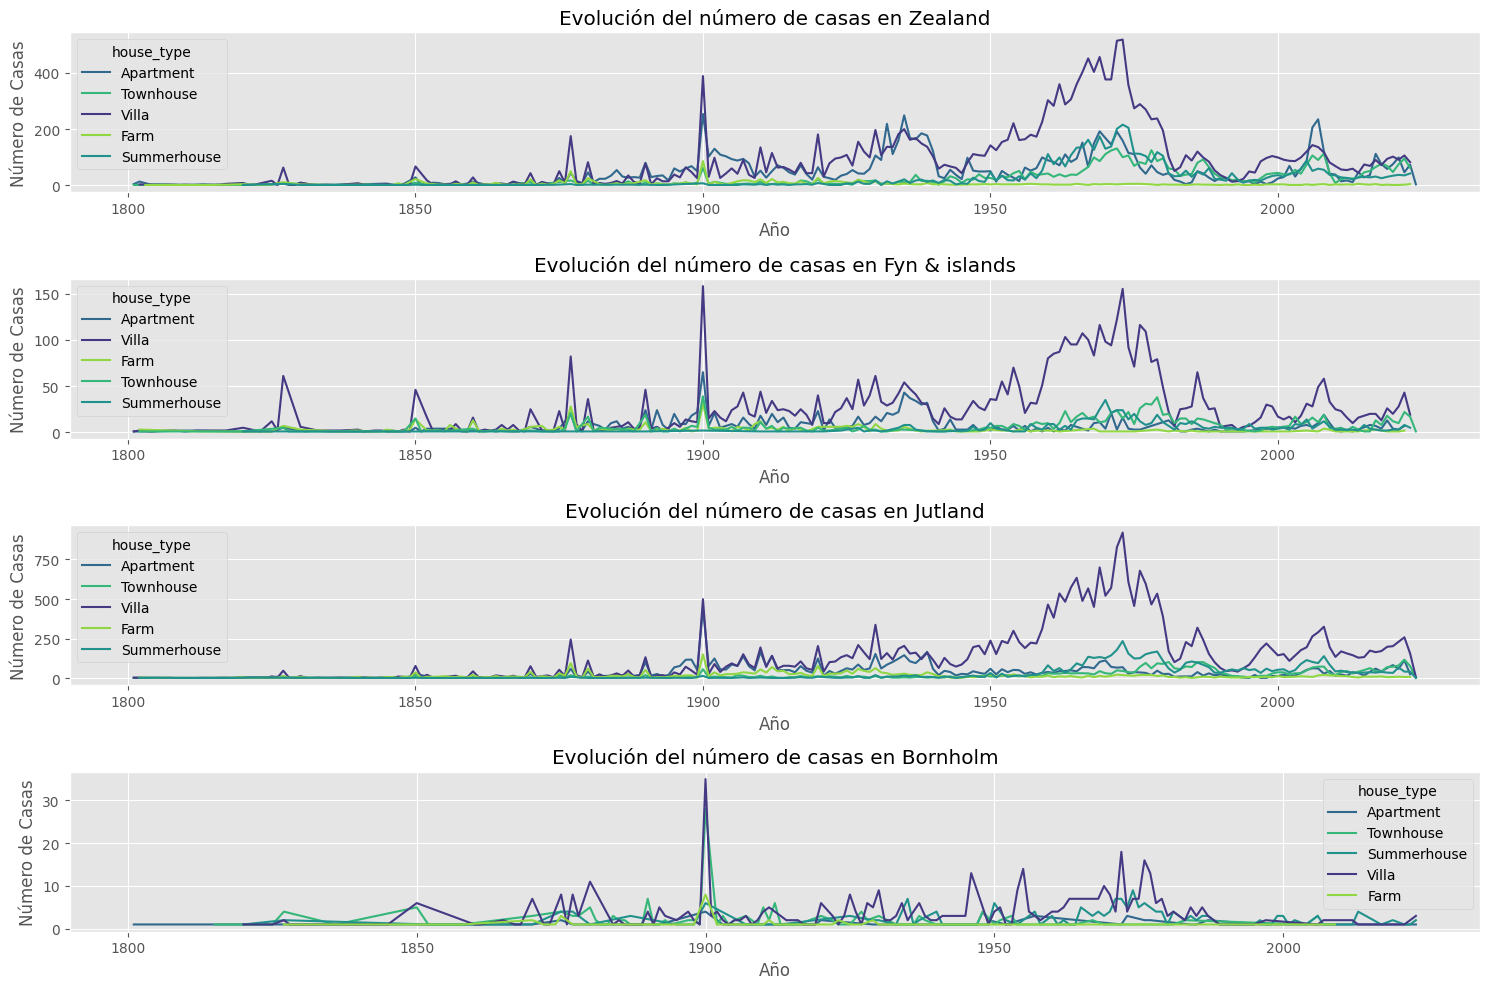

In [18]:
# funcion para contar
def contar(data, column1, column2):
  df = data.groupby(['year_build', column1, column2]).size().reset_index(name='counts')
  return df

# Crear el gráfico
plt.figure(figsize=(15, 10))

# Obtener las regiones y tipos de casa únicos
regiones = df_houses_year['region'].unique()
tipos_de_casa = df_houses_year['house_type'].unique()

# Crear una paleta de colores
palette = sns.color_palette("viridis", len(tipos_de_casa))
color_dict = dict(zip(tipos_de_casa, palette))

# Crear un gráfico para cada región
for i, region in enumerate(regiones):
  df = contar(df_houses_year, 'region', 'house_type')
  plt.subplot(len(regiones), 1, i + 1)
  region_data = df[df['region'] == region]
  sns.lineplot(data=region_data, x='year_build', y='counts', hue='house_type', palette=color_dict)
  plt.title(f'Evolución del número de casas en {region}')
  plt.xlabel('Año')
  plt.ylabel('Número de Casas')

plt.tight_layout()
plt.show()

### Evolución de casas según región

Donde menos casas se construyen es en Bornholm, se pueden observar varios booms inmobiliarios en 1900 y en torno a 1975. Jutland y Zealand son las regiones con más construcciones a lo largo de los años, apreciamos que se ha visto una evolución en los últimos años.

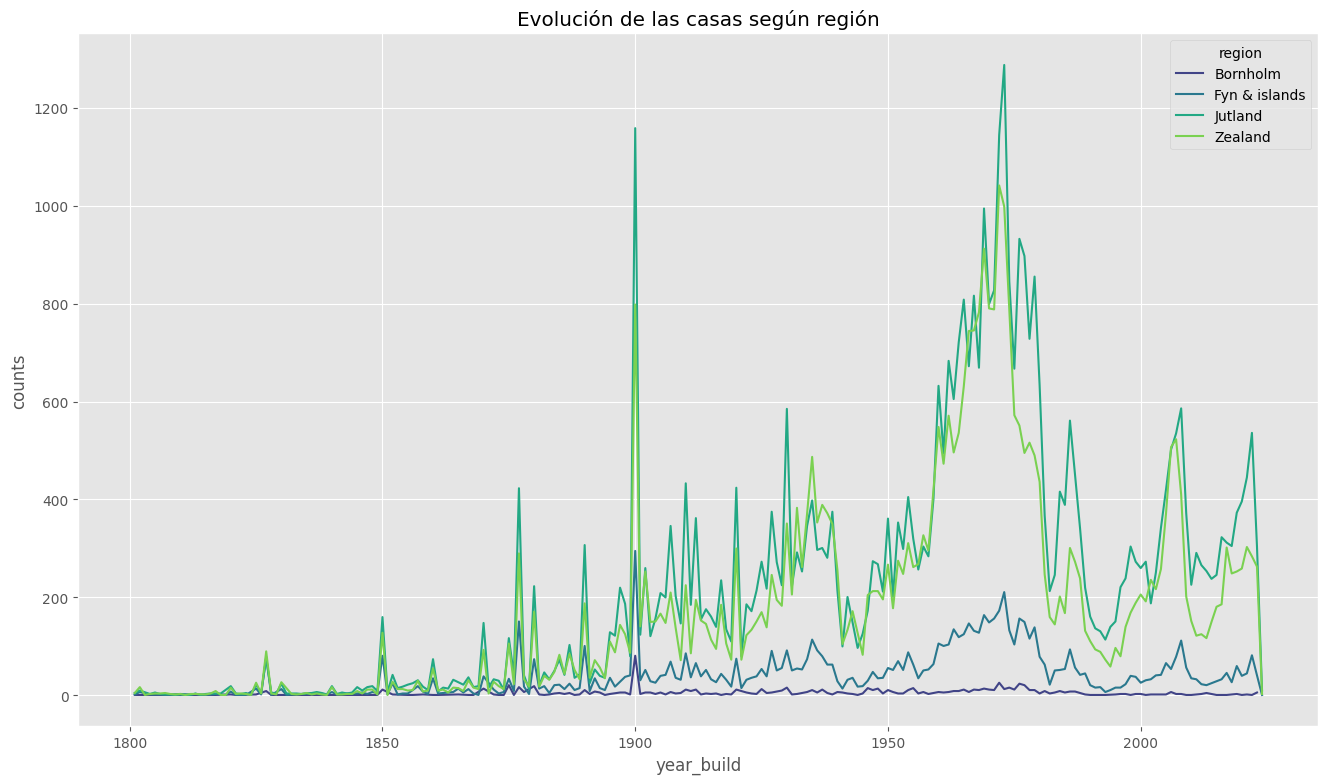

In [19]:
# funcion para contar solo una columna
def contar_una(data, column1):
  df = data.groupby(['year_build', column1]).size().reset_index(name='counts')
  return df

# Gráfico Evolución de número de casas según región a lo largo de los años
df = contar_una(df_houses_year, 'region')
plt.figure(figsize=(16, 9))
sns.lineplot(x='year_build', y='counts', data=df, hue='region', palette='viridis')
plt.title('Evolución de las casas según región')
plt.show()

### Evolución del número de habitaciones según región

En cuanto a años anteriores en la evolución de las casas según sus habitaciones, podemos ver que siempre han predominado las casas de 2 habitaciones y por encima de 10 hay un número muy reducido

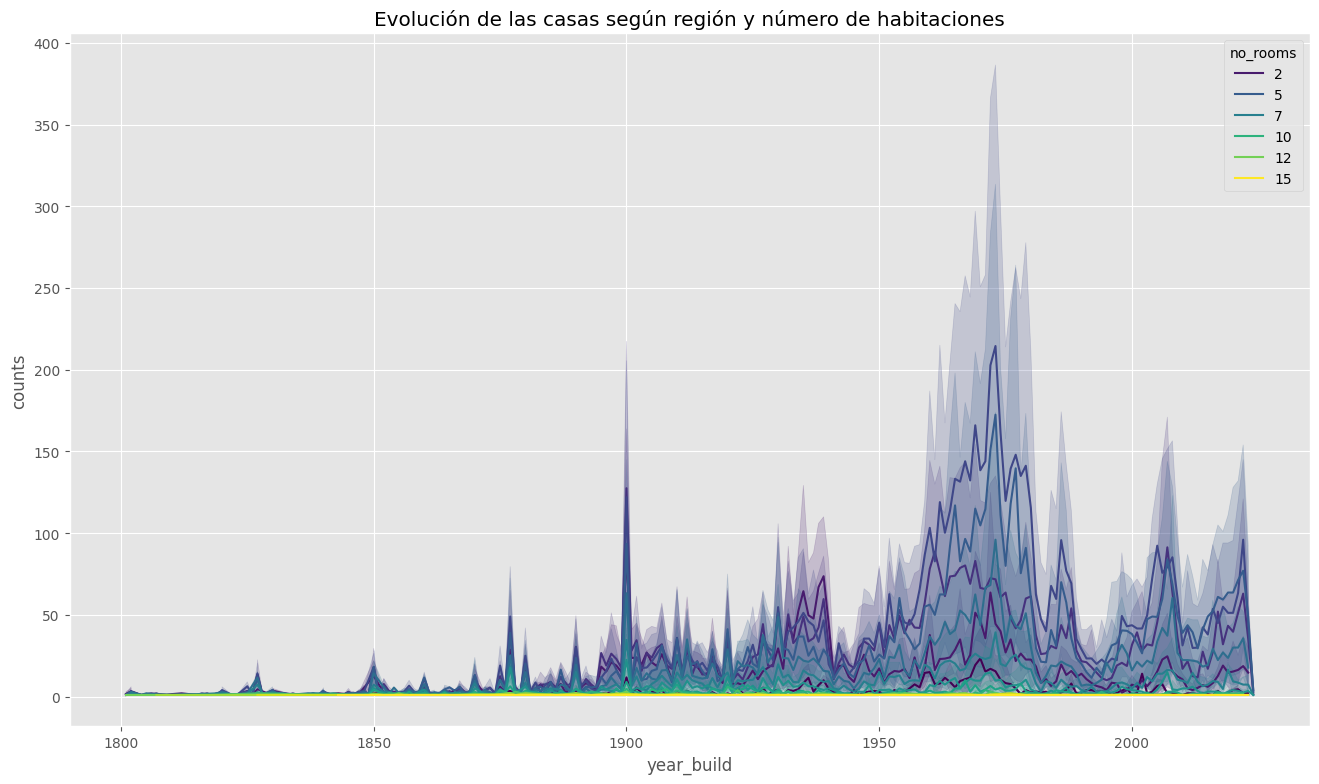

In [20]:
# gráfico Evolución del número de casas con diferente numero de habitaciones según región a lo largo de los años
df = contar(df_houses_year, 'region', 'no_rooms')
plt.figure(figsize=(16, 9))
sns.lineplot(x='year_build', y='counts', data=df, hue='no_rooms', palette='viridis')
plt.title('Evolución de las casas según región y número de habitaciones')
plt.show()

### Ventas

En este gráfico podemos ver que las ventas han ido subiendo obteniendo un pico máximo en 2021 y en los años posteriores hasta 2024 ha sufrido una leve caída. 

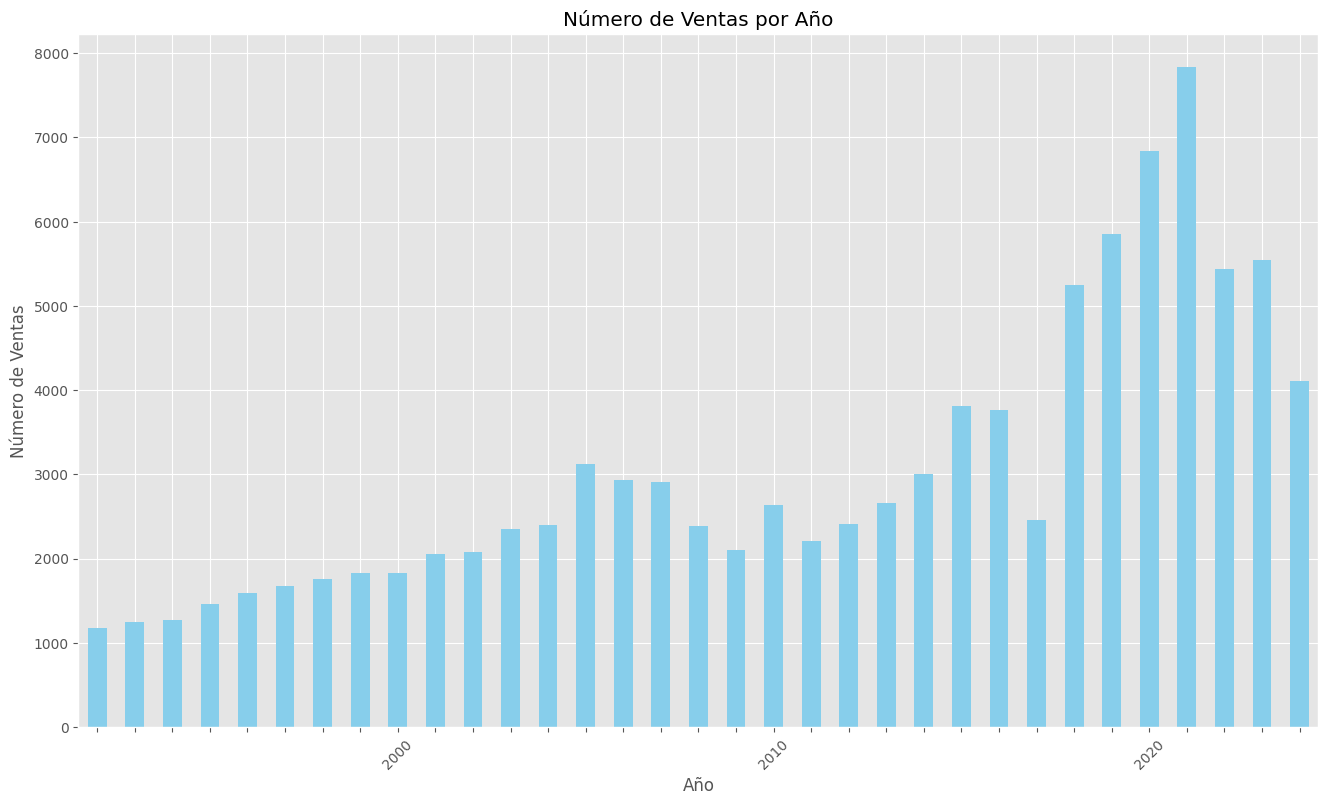

In [21]:
# Extraer el año de la columna 'date'
df_houses['year'] = pd.to_datetime(df_houses['date']).dt.year

# Contar el número de ventas por año
ventas_por_año = df_houses['year'].value_counts().sort_index()

# Graficar el número de ventas por año
plt.figure(figsize=(16, 9))
ax = ventas_por_año.plot(kind='bar', color='skyblue')
plt.title('Número de Ventas por Año')
plt.xlabel('Año')
plt.ylabel('Número de Ventas')

# Configurar los labels para que solo se muestren los años que terminan en 0
ticks = ventas_por_año.index
tick_labels = [str(year) if year % 10 == 0 else '' for year in ticks]
ax.set_xticklabels(tick_labels, rotation=45)

plt.show()

## 2. Predicciones Sobre Futuras Construcciones

### Predicción de la evolución de precios con variables macroeconómicas de interés e inflación

La tendencia de subida de precios seguirá en años futuros en todas las regiones, excepto en Bornholm donde los precios bajarán, también destacamos que Fynn superará con precios más altos a Zealand.

Puntuación para Zealand: 0.30796943381964115
Puntuación para Fyn & islands: 0.3023825163486026
Puntuación para Jutland: 0.17904339641050093
Puntuación para Bornholm: 0.5568756284452558


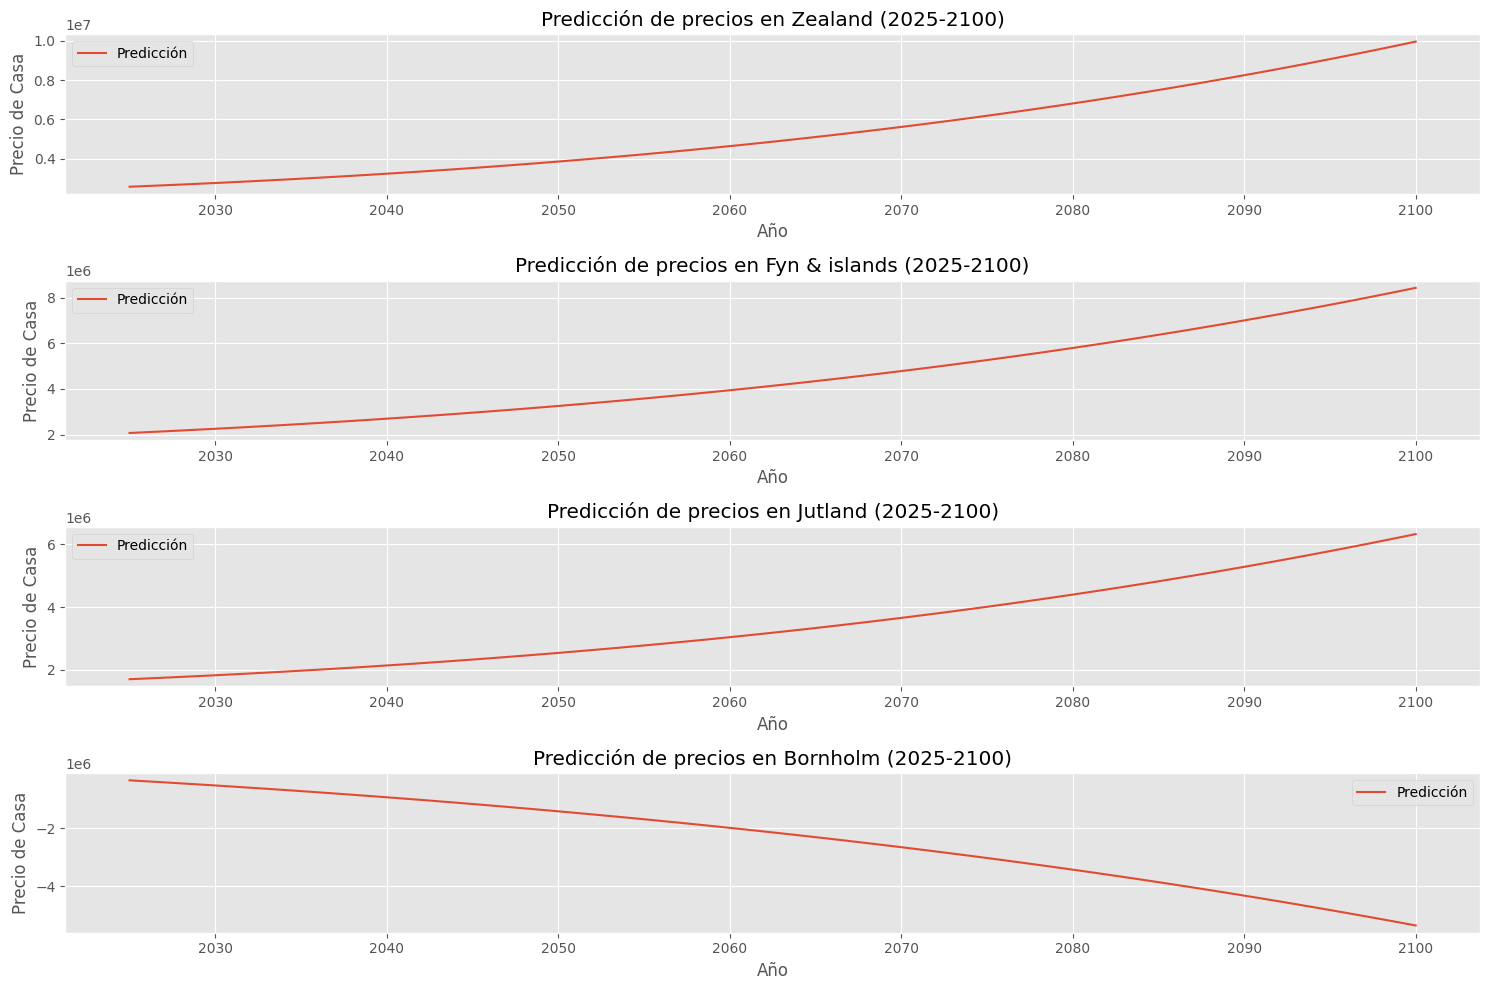

In [22]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

regiones = df_houses['region'].unique()
predicciones = {}

for region in regiones:
    region_data = df_houses[df_houses['region'] == region]
    X = region_data[['year_build', 'sqm', 'nom_interest_rate%', 'dk_ann_infl_rate%']]
    y = region_data['purchase_price']
    
    # Pipeline con variables polinómicas de grado 5 para sobreajustar y obtener una puntuación alta
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('poly', PolynomialFeatures(degree=5, include_bias=False)),
        ('scaler', StandardScaler()),
        ('lr', LinearRegression())
    ])
    
    pipeline.fit(X, y)
    score = pipeline.score(X, y)
    print(f"Puntuación para {region}: {score}")
    
    # Predecir precios de 2025 a 2100 usando las medias para las otras variables
    future_years = np.arange(2025, 2101)
    future_data = pd.DataFrame({
        'year_build': future_years,
        'sqm': np.mean(region_data['sqm']),
        'nom_interest_rate%': np.mean(region_data['nom_interest_rate%']),
        'dk_ann_infl_rate%': np.mean(region_data['dk_ann_infl_rate%'])
    })
    
    future_prices = pipeline.predict(future_data)
    predicciones[region] = (future_years, future_prices)

# Graficar las predicciones
plt.figure(figsize=(15, 10))
for i, region in enumerate(regiones):
    plt.subplot(len(regiones), 1, i + 1)
    years, prices = predicciones[region]
    plt.plot(years, prices, label='Predicción')
    plt.title(f'Predicción de precios en {region} (2025-2100)')
    plt.xlabel('Año')
    plt.ylabel('Precio de Casa')
    plt.legend()

plt.tight_layout()
plt.show()


### Tipos de casa por región en los próximos años

Sobre los tipos de casa, vemos que en años futuros cambia la tendencia, ya que las casas de verano aumentarán y las villas sufrirán una caída en las construcciones, sobretodo en Jutland, a su vez podemos destacar que las casas de pueblo tendrán una subida en Bornholm.

Puntuación para Zealand - Villa: 0.3951605994040006
Puntuación para Zealand - Apartment: 0.1728317607229357
Puntuación para Zealand - Summerhouse: 0.4529897221820447
Puntuación para Zealand - Townhouse: 0.3943778066693071
Puntuación para Zealand - Farm: 0.3340041165250497
Puntuación para Fyn & islands - Villa: 0.30198008985363123
Puntuación para Fyn & islands - Apartment: 0.3328801823116765
Puntuación para Fyn & islands - Summerhouse: 0.6370606278511821
Puntuación para Fyn & islands - Townhouse: 0.3570851200068563
Puntuación para Fyn & islands - Farm: 0.5018470703362756
Puntuación para Jutland - Villa: 0.40172817985845943
Puntuación para Jutland - Apartment: 0.17818687335328398
Puntuación para Jutland - Summerhouse: 0.37313841918861734
Puntuación para Jutland - Townhouse: 0.4315769996292941
Puntuación para Jutland - Farm: 0.30443851259399224
Puntuación para Bornholm - Villa: 0.5533863489825438
Puntuación para Bornholm - Apartment: 1.0
Puntuación para Bornholm - Summerhouse: 1.0
Puntuac

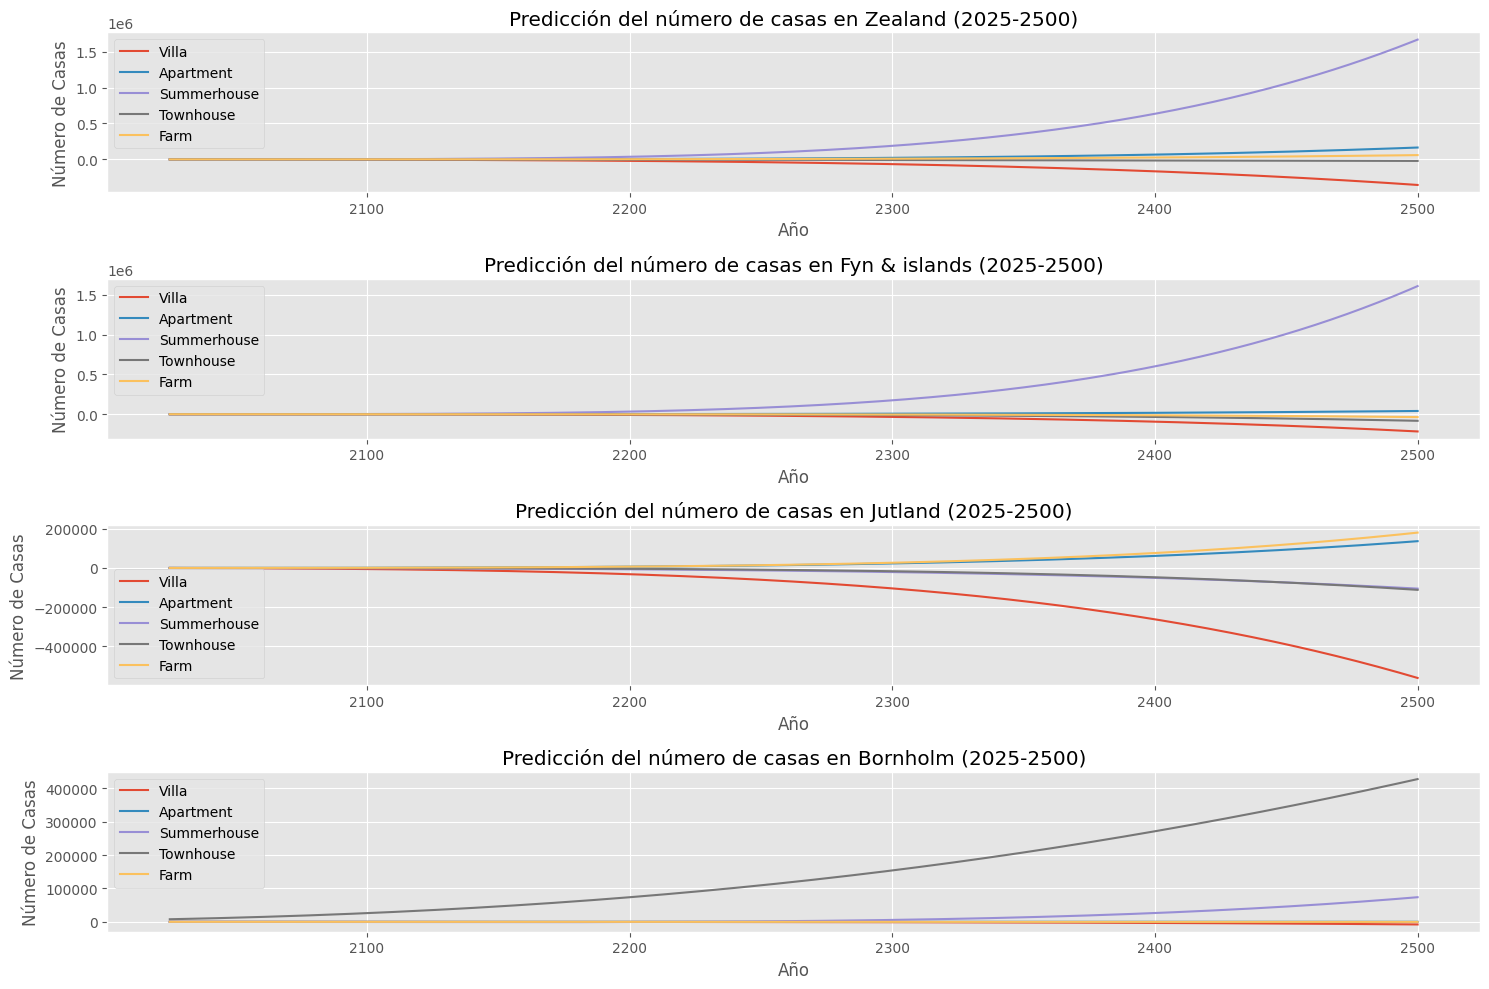

In [26]:
df_houses['no_rooms'] = df_houses['no_rooms'].fillna(df_houses['no_rooms'].median())

# Contar el número de casas por año para cada región y tipo de casa
df_houses['Numero_de_Casas'] = df_houses.groupby(['region', 'house_type', 'year_build'])['house_id'].transform('count')

regiones = df_houses['region'].unique()
tipos_de_casa = df_houses['house_type'].unique()
predicciones = {}

for region in regiones:
    predicciones[region] = {}
    for tipo in tipos_de_casa:
        region_tipo_data = df_houses[(df_houses['region'] == region) & (df_houses['house_type'] == tipo)]
        if region_tipo_data['year_build'].nunique() < 3:
            continue
        
        # Se añaden más características
        X = region_tipo_data[['year_build', 'nom_interest_rate%', 'dk_ann_infl_rate%', 'sqm', 'no_rooms']]
        y = region_tipo_data['Numero_de_Casas']
        
        pipeline_model = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('poly', PolynomialFeatures(degree=5, include_bias=False)),
            ('scaler', StandardScaler()),
            ('lr', LinearRegression())
        ])
        
        pipeline_model.fit(X, y)
        score = pipeline_model.score(X, y)
        print(f"Puntuación para {region} - {tipo}: {score}")
        
        # Se utilizan valores medios para las predicciones
        future_years = pd.DataFrame(np.arange(2025, 2501), columns=['year_build'])
        future_years['nom_interest_rate%'] = np.mean(region_tipo_data['nom_interest_rate%'])
        future_years['dk_ann_infl_rate%'] = np.mean(region_tipo_data['dk_ann_infl_rate%'])
        future_years['sqm'] = np.mean(region_tipo_data['sqm'])
        future_years['no_rooms'] = np.mean(region_tipo_data['no_rooms'])
        
        future_casas = pipeline_model.predict(future_years)
        predicciones[region][tipo] = (future_years['year_build'].values, future_casas)

plt.figure(figsize=(15, 10))
for i, region in enumerate(regiones):
    plt.subplot(len(regiones), 1, i + 1)
    for tipo in tipos_de_casa:
        if tipo in predicciones[region]:
            years, casas = predicciones[region][tipo]
            plt.plot(years, casas, label=tipo)
    plt.title(f'Predicción del número de casas en {region} (2025-2500)')
    plt.xlabel('Año')
    plt.ylabel('Número de Casas')
    plt.legend()

plt.tight_layout()
plt.show()


### Predicción de los precios según tipo de casa por región

En un futuro, vemos que por norma general las casas de campo siguen subiendo en todas las regiones aunque los apartamentos sufren una reducción de los precios en Bornholm y jutland, los demás tipos se mantienen constantes sin mucha variación, exceptuando de las granjas que aumentarán considerablemente sus precios en la región de Bornholm, las cuales en las demás regiones se mantienen bastante constantes.

Puntuación para Zealand - Villa: 0.25072081243992217
Puntuación para Zealand - Apartment: 0.44661727822518593
Puntuación para Zealand - Summerhouse: 0.30751430467109
Puntuación para Zealand - Townhouse: 0.3517952380134388
Puntuación para Zealand - Farm: 0.33808486026907825
Puntuación para Fyn & islands - Villa: 0.17907499516095338
Puntuación para Fyn & islands - Apartment: 0.23065898654956518
Puntuación para Fyn & islands - Summerhouse: 0.8189624259227783
Puntuación para Fyn & islands - Townhouse: 0.3357419957350791
Puntuación para Fyn & islands - Farm: 0.3659576753744799
Puntuación para Jutland - Villa: 0.19373786534700344
Puntuación para Jutland - Apartment: 0.20113636970491655
Puntuación para Jutland - Summerhouse: 0.2810165495913466
Puntuación para Jutland - Townhouse: 0.28041359066028226
Puntuación para Jutland - Farm: 0.16619520875521254
Puntuación para Bornholm - Villa: 0.3045027947268578
Puntuación para Bornholm - Apartment: 0.923110655570506
Puntuación para Bornholm - Summerho

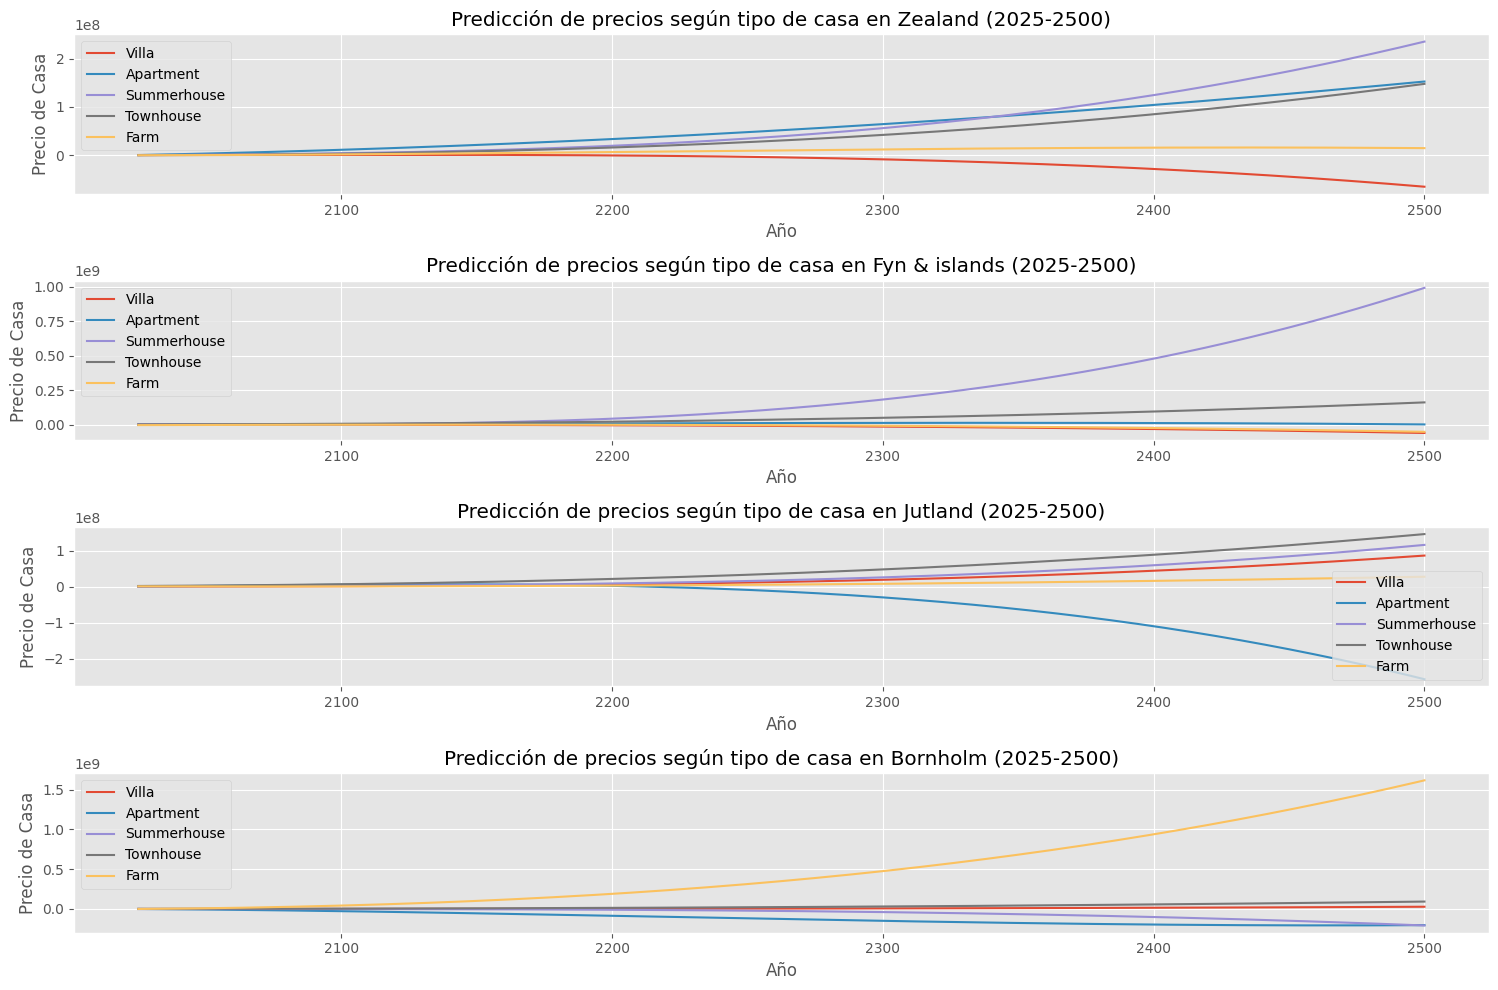

In [27]:
predicciones = {}

for region in regiones:
    predicciones[region] = {}
    for tipo in tipos_de_casa:
        region_tipo_data = df_houses[(df_houses['region'] == region) & (df_houses['house_type'] == tipo)]
        
        # Evitar fallos si no hay suficientes datos
        if len(region_tipo_data) < 2:
            continue
        
        # Añadimos más características y creamos un pipeline que incluya polinomios
        X = region_tipo_data[['year_build', 'sqm', 'nom_interest_rate%', 'dk_ann_infl_rate%']]
        y = region_tipo_data['purchase_price']
        
        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('poly', PolynomialFeatures(degree=3, include_bias=False)),
            ('scaler', StandardScaler()),
            ('lr', LinearRegression())
        ])
        
        pipeline.fit(X, y)
        score = pipeline.score(X, y)
        print(f"Puntuación para {region} - {tipo}: {score}")
        
        # Predecir precios de 2025 a 2500 con valores suavizados y medias para las demás variables
        future_years = np.arange(2025, 2501)
        metros_min, metros_max = region_tipo_data['sqm'].min(), region_tipo_data['sqm'].max()
        future_metros = np.linspace(metros_min, metros_max if metros_max > metros_min else metros_min + 1, len(future_years))
        
        future_data = pd.DataFrame({
            'year_build': future_years,
            'sqm': future_metros,
            'nom_interest_rate%': region_tipo_data['nom_interest_rate%'].mean(),
            'dk_ann_infl_rate%': region_tipo_data['dk_ann_infl_rate%'].mean()
        })
        
        future_precios = pipeline.predict(future_data)
        predicciones[region][tipo] = (future_years, future_metros, future_precios)

plt.figure(figsize=(15, 10))
for i, region in enumerate(regiones):
    plt.subplot(len(regiones), 1, i + 1)
    for tipo in tipos_de_casa:
        if tipo in predicciones[region]:
            years, metros, precios = predicciones[region][tipo]
            plt.plot(years, precios, label=f'{tipo}')
    plt.title(f'Predicción de precios según tipo de casa en {region} (2025-2500)')
    plt.xlabel('Año')
    plt.ylabel('Precio de Casa')
    plt.legend()

plt.tight_layout()
plt.show()

### Predicción de los metros cuadrados por región y según tipo de casa

En cuanto a metros cuadrados podemos apreciar que los apartamentos se mantendrán en 100 m2 por lo general como habíamos visto en el análisis univariante, pero vemos importantes subidas en todas las regiones en casas de verano, villas y granjas, excepto en Bornholm que casi todo se mantiene constante, menos las granjas disminuirán de tamaño.

Puntuación para Zealand - Villa: 0.5561
Puntuación para Zealand - Apartment: 0.5523
Puntuación para Zealand - Summerhouse: 0.4444
Puntuación para Zealand - Townhouse: 0.5715
Puntuación para Zealand - Farm: 0.5713
Puntuación para Fyn & islands - Villa: 0.5423
Puntuación para Fyn & islands - Apartment: 0.6752
Puntuación para Fyn & islands - Summerhouse: 0.4260
Puntuación para Fyn & islands - Townhouse: 0.6245
Puntuación para Fyn & islands - Farm: 0.6016
Puntuación para Jutland - Villa: 0.5398
Puntuación para Jutland - Apartment: 0.4967
Puntuación para Jutland - Summerhouse: 0.3950
Puntuación para Jutland - Townhouse: 0.6366
Puntuación para Jutland - Farm: 0.5389
Puntuación para Bornholm - Villa: 0.6306
Puntuación para Bornholm - Apartment: 0.9945
Puntuación para Bornholm - Summerhouse: 0.8174
Puntuación para Bornholm - Townhouse: 0.7588
Puntuación para Bornholm - Farm: 0.9774


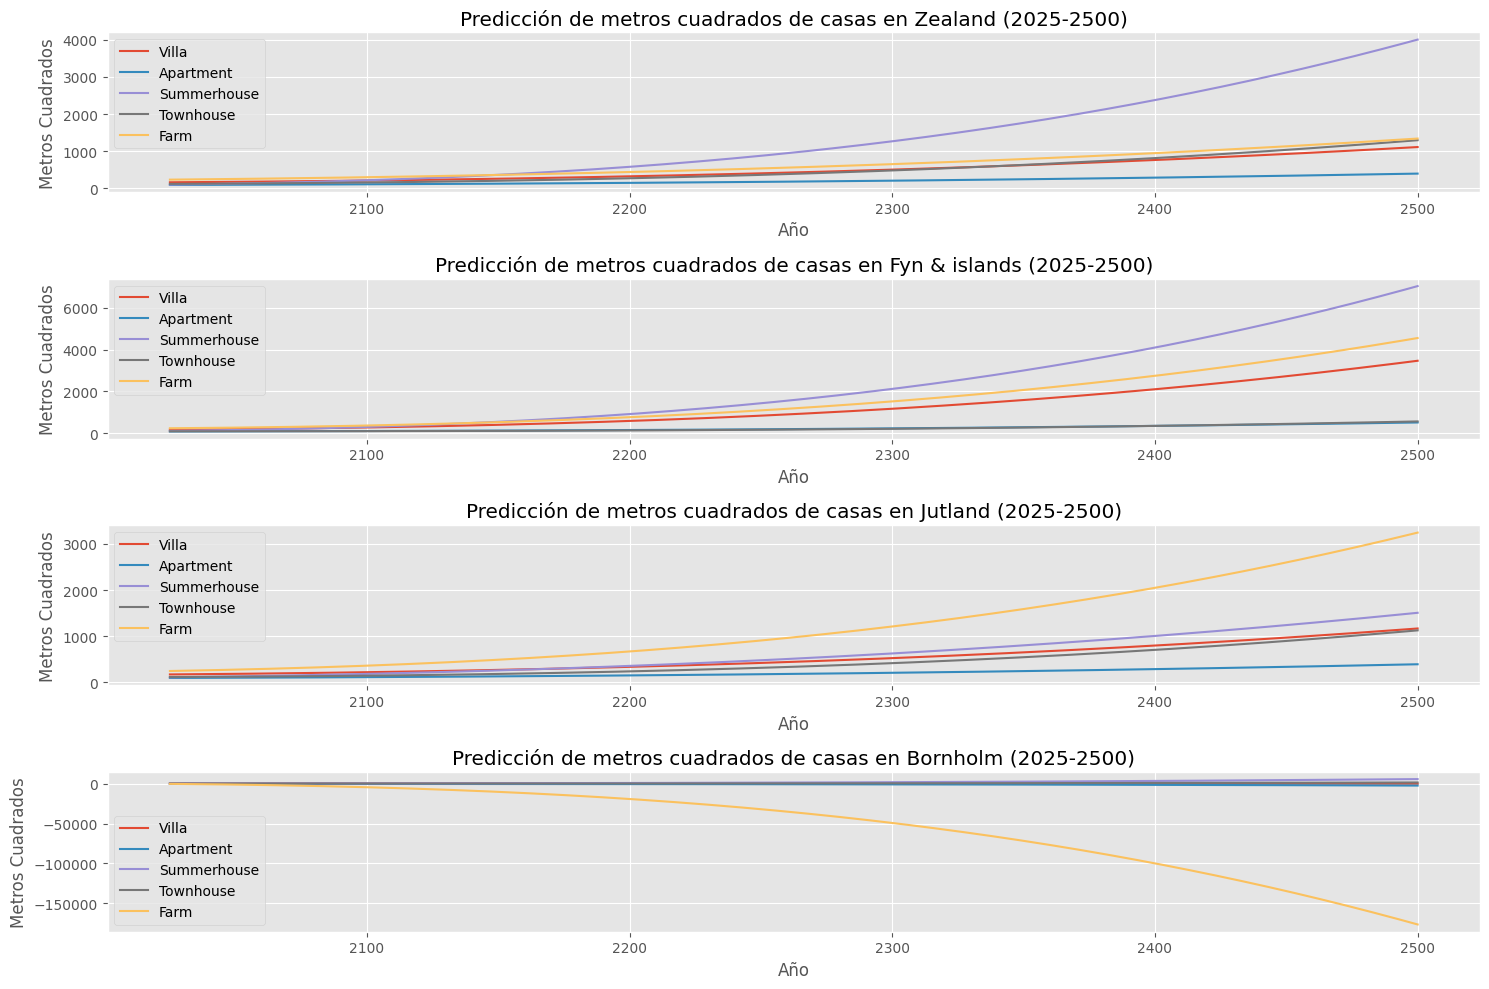

In [28]:
# Se añaden características adicionales y un pipeline con polinómicos para mejorar la precisión
X_cols = ['year_build', 'no_rooms', 'purchase_price', 'nom_interest_rate%', 'dk_ann_infl_rate%']

regiones = df_houses['region'].unique()
tipos_de_casa = df_houses['house_type'].unique()
predicciones = {}

for region in regiones:
    predicciones[region] = {}
    for tipo in tipos_de_casa:
        region_tipo_data = df_houses[(df_houses['region'] == region) & (df_houses['house_type'] == tipo)]
        # Evitar errores si no hay suficientes datos
        if len(region_tipo_data) < 2:
            continue
        
        X = region_tipo_data[X_cols]
        y = region_tipo_data['sqm']
        
        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('poly', PolynomialFeatures(degree=3, include_bias=False)),
            ('scaler', StandardScaler()),
            ('lr', LinearRegression())
        ])
        
        pipeline.fit(X, y)
        score = pipeline.score(X, y)
        print(f"Puntuación para {region} - {tipo}: {score:.4f}")
        
        # Para predecir de 2025 a 2500
        future_data = pd.DataFrame({'year_build': np.arange(2025, 2501)})
        future_data['no_rooms'] = region_tipo_data['no_rooms'].mean()
        future_data['purchase_price'] = region_tipo_data['purchase_price'].mean()
        future_data['nom_interest_rate%'] = region_tipo_data['nom_interest_rate%'].mean()
        future_data['dk_ann_infl_rate%'] = region_tipo_data['dk_ann_infl_rate%'].mean()
        
        future_sqm = pipeline.predict(future_data)
        predicciones[region][tipo] = (future_data['year_build'].values, future_sqm)

plt.figure(figsize=(15, 10))
for i, region in enumerate(regiones):
    plt.subplot(len(regiones), 1, i + 1)
    for tipo in tipos_de_casa:
        if tipo in predicciones[region]:
            years, metros = predicciones[region][tipo]
            plt.plot(years, metros, label=tipo)
    plt.title(f'Predicción de metros cuadrados de casas en {region} (2025-2500)')
    plt.xlabel('Año')
    plt.ylabel('Metros Cuadrados')
    plt.legend()

plt.tight_layout()
plt.show()

### Predicción de número de casas según número de habitaciones por regiones.

La tendencia cambia en años futuros, ya que podemos ver que en Bornholm las casas de 2 habitaciones disminuiran drásticamente al igual que las de 1, manteniendo constante las demás casas, en las demás regiones vemos que en Zealand y Jutland disminuye bastante el número de casas con 5 habitaciones y en Fynn destaca el aumento de casas con 6 habitaciones.

Puntuación para Zealand - 5 habitaciones: 0.43840753348815087
Puntuación para Zealand - 2 habitaciones: 0.3383132040292033
Puntuación para Zealand - 4 habitaciones: 0.46757411709434793
Puntuación para Zealand - 3 habitaciones: 0.4972423044525406
Puntuación para Zealand - 6 habitaciones: 0.43443429733763494
Puntuación para Zealand - 8 habitaciones: 0.1860341462694025
Puntuación para Zealand - 7 habitaciones: 0.3307898734261461
Puntuación para Zealand - 10 habitaciones: 0.18063865110656474
Puntuación para Zealand - 9 habitaciones: 0.12195371996460869
Puntuación para Zealand - 1 habitaciones: 0.2528519706167992
Puntuación para Zealand - 12 habitaciones: 0.03955686992763097
Puntuación para Zealand - 11 habitaciones: 0.04038980866419206
Puntuación para Zealand - 13 habitaciones: 0.1930806752655745
Puntuación para Zealand - 15 habitaciones: 1.0
Puntuación para Zealand - 14 habitaciones: 1.0
Puntuación para Fyn & islands - 5 habitaciones: 0.24001123814098846
Puntuación para Fyn & islands - 2 

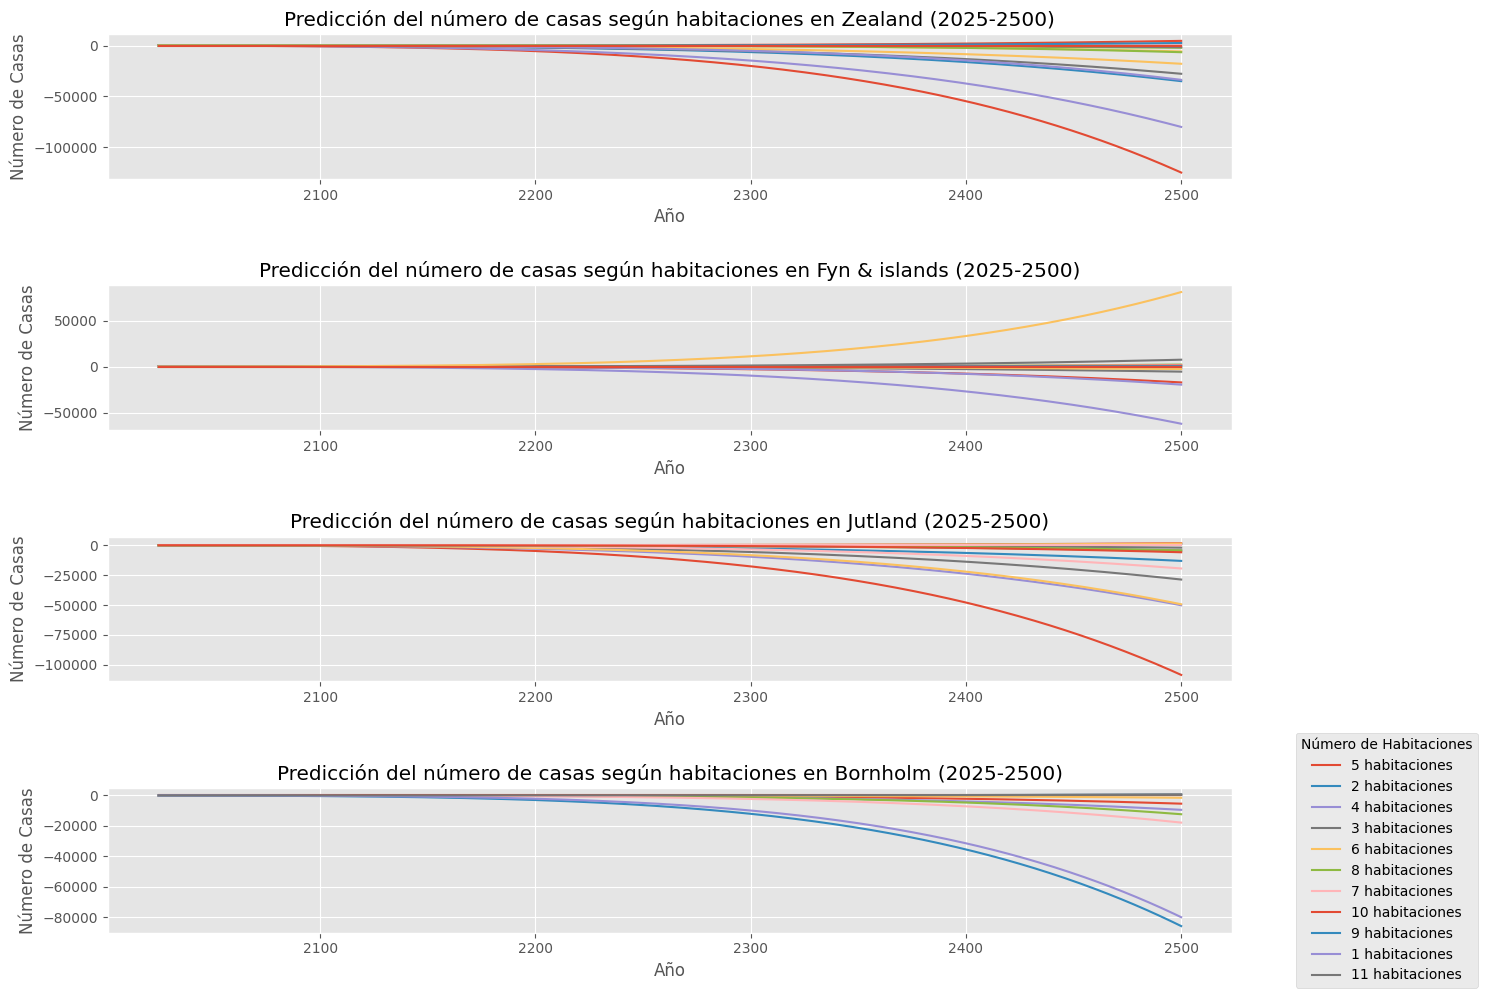

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression

# Contar el número de casas para cada combinación de región y habitaciones
df_counts = df_houses.groupby(['year_build', 'region', 'no_rooms']).size().reset_index(name='num_houses')

regiones = df_houses['region'].unique()
num_habitaciones = df_houses['no_rooms'].unique()
predicciones = {}

for region in regiones:
    predicciones[region] = {}
    for num_hab in num_habitaciones:
        region_hab_data = df_counts[(df_counts['region'] == region) & (df_counts['no_rooms'] == num_hab)]
        if len(region_hab_data) > 1:  # Al menos dos muestras para entrenar
            X = region_hab_data[['year_build']]
            y = region_hab_data['num_houses']
            
            pipeline = Pipeline([
                ('poly', PolynomialFeatures(degree=5, include_bias=False)),
                ('scaler', StandardScaler()),
                ('lr', LinearRegression())
            ])
            
            pipeline.fit(X, y)
            score = pipeline.score(X, y)
            print(f"Puntuación para {region} - {num_hab} habitaciones: {score}")
            
            # Predecir de 2025 a 2500
            future_years = pd.DataFrame({'year_build': np.arange(2025, 2501)})
            future_houses = pipeline.predict(future_years)
            predicciones[region][num_hab] = (future_years['year_build'].values, future_houses)

# Graficar las predicciones
plt.figure(figsize=(15, 10))
for i, region in enumerate(regiones):
    plt.subplot(len(regiones), 1, i + 1)
    for num_hab in num_habitaciones:
        if num_hab in predicciones[region]:
            years, houses = predicciones[region][num_hab]
            plt.plot(years, houses, label=f'{num_hab} habitaciones')
    plt.title(f'Predicción del número de casas según habitaciones en {region} (2025-2500)')
    plt.xlabel('Año')
    plt.ylabel('Número de Casas')

plt.legend(title='Número de Habitaciones', bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=1)
plt.tight_layout()
plt.show()

### Clasificación de viviendas con RandomForest

Aquí podemos ver una clasificación de viviendas realizada con RandomForestClassifier, hasta ahora el modelo ha sido regresión lineal para las anteriores predicciones, donde podemos ver que las casas se clasifican según su precio para diferentes categorias sociales en caro, medio y barato, apreciamos que la mayoría de casas son categorizadas como caras y medio y barato tienen menor número, a su vez destaca el dato de que hay más casas baratas con mayor tamaño, y la mayoría de casas se agrupan por debajo de los 600 metros cuadrados.

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.73      0.82      0.77     13295
           1       0.31      0.21      0.25      1882
           2       0.37      0.28      0.32      4823

    accuracy                           0.63     20000
   macro avg       0.47      0.44      0.45     20000
weighted avg       0.60      0.63      0.61     20000

Matriz de confusión:
[[10872   518  1905]
 [ 1018   404   460]
 [ 3084   377  1362]]
Puntuación:  1.0


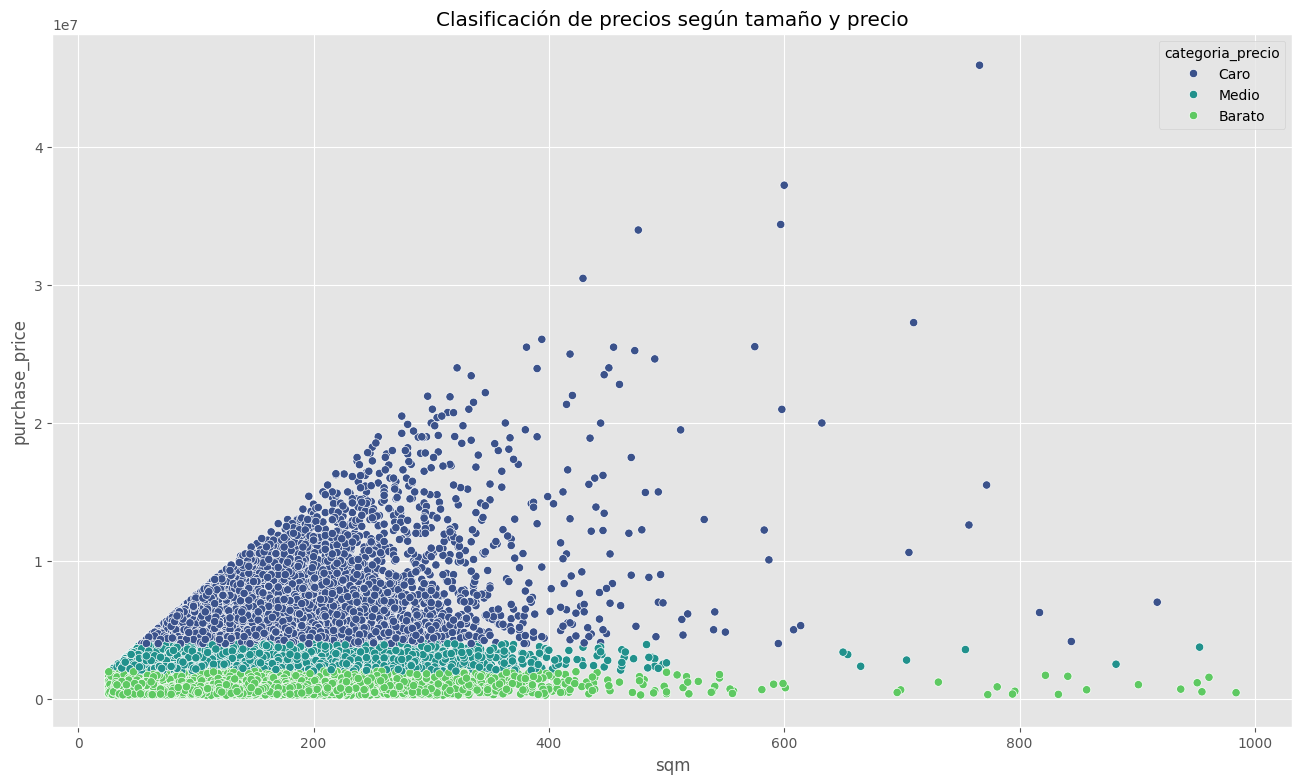

In [30]:
# Crear categorías de precio
def categorizar_precio(precio):
    if precio < 2000000:  # Barato
        return 'Barato'
    elif 2000000 <= precio < 4000000:  # Medio
        return 'Medio'
    else:  # Caro
        return 'Caro'

df_houses['categoria_precio'] = df_houses['purchase_price'].apply(categorizar_precio)

# Convertir categorías en valores numéricos
label_encoder = LabelEncoder()
df_houses['categoria_precio_encoded'] = label_encoder.fit_transform(df_houses['categoria_precio'])

# Asegurarse de que 'year_build' es un entero
df_houses['year_build'] = pd.to_numeric(df_houses['year_build'], errors='coerce')
df_houses = df_houses.dropna(subset=['year_build'])
df_houses['year_build'] = df_houses['year_build'].astype(int)

# Seleccionar características para el modelo
X = df_houses[['no_rooms', 'sqm', 'year_build', 'house_type']]
y = df_houses['categoria_precio_encoded']

# Convertir variables categóricas en dummies
X = pd.get_dummies(X, drop_first=True)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluar el modelo
y_pred = rf.predict(X_test)
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("Puntuación: ", score)
# Gráfico con la clasificación
plt.figure(figsize=(16, 9))
sns.scatterplot(x='sqm', y='purchase_price', data=df_houses, hue='categoria_precio', palette='viridis')
plt.title('Clasificación de precios según tamaño y precio')
plt.show()


### Predicción de probabilidad de venta

Con el mismo modelo, podemos ver en este gráfico la probabilidad de la venta de las casas de Dinamarca, donde vemos que las casas menos probables de vender son las casas con el precio bajo y más pequeñas como también con precio alto y pequeñas, es decir las casas más grandes se venden mejor, también vemos que los datos más céntricos tienen una probabilidad media alta.

[[ 1316   361]
 [  251 18072]]
              precision    recall  f1-score   support

           0       0.84      0.78      0.81      1677
           1       0.98      0.99      0.98     18323

    accuracy                           0.97     20000
   macro avg       0.91      0.89      0.90     20000
weighted avg       0.97      0.97      0.97     20000



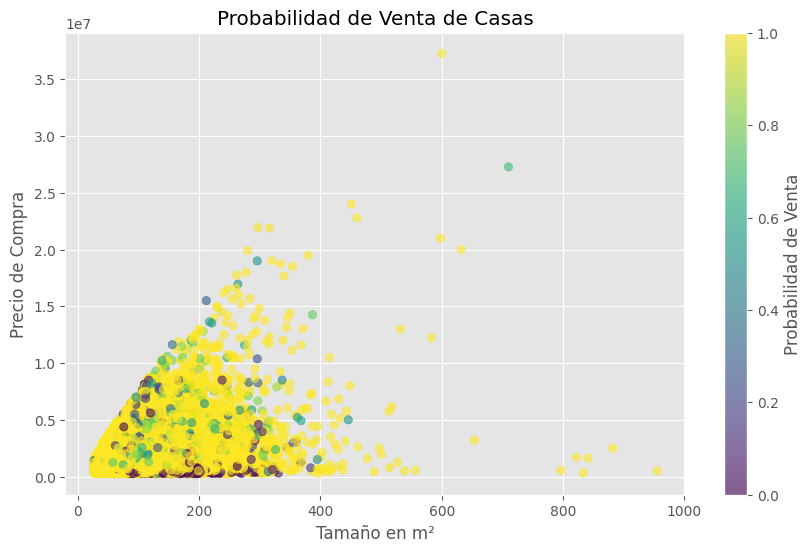

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Crear la columna 'year' extrayendo el año de la columna 'date'
df_houses['year'] = pd.to_datetime(df_houses['date']).dt.year

# Crear la columna 'sold' como objetivo (1: vendida, 0: no vendida)
df_houses['sold'] = df_houses.apply(lambda x: 1 if x['year'] > x['year_build'] else 0, axis=1)

# Seleccionar características y variable objetivo
features = ['year_build', 'no_rooms', 'sqm', 'purchase_price']
target = 'sold'

# Preparar los datos
X = df_houses[features]
y = df_houses[target]

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Obtener probabilidades predichas
y_probs = model.predict_proba(X_test)[:, 1]

# Crear un DataFrame con los resultados
results = X_test.copy()
results['sold'] = y_test
results['prob_sold'] = y_probs

# Gráfico de las probabilidades de venta
plt.figure(figsize=(10, 6))
plt.scatter(results['sqm'], results['purchase_price'], c=results['prob_sold'], cmap='viridis', alpha=0.6)
plt.colorbar(label='Probabilidad de Venta')
plt.xlabel('Tamaño en m²')
plt.ylabel('Precio de Compra')
plt.title('Probabilidad de Venta de Casas')
plt.show()

### Predicción de ventas por región

En años futuros la tendendencia de la leve caída en los últimos años cambiará en la mayoría de regiones, aumentando el número de ventas, excepto en Bornholm que sufrirá una leve caída de ventas aunque manteniendose casi constante. La mayor subida de ventas la podemos apreciar en Jutland.

Puntuación para Zealand: 0.7805127872768163
Puntuación para Fyn & islands: 0.6660499459525551
Puntuación para Jutland: 0.697587435102462
Puntuación para Bornholm: 0.6840115094902421


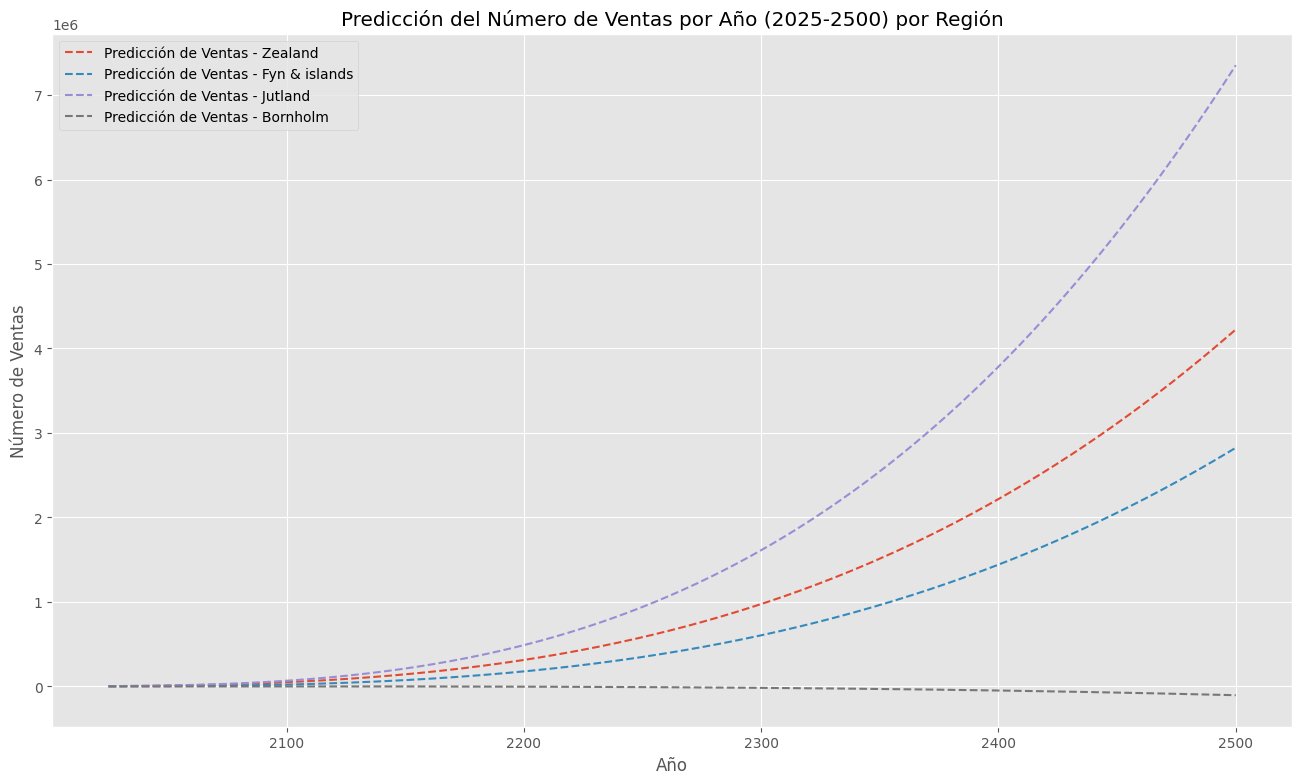

In [32]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Crear un diccionario para almacenar las predicciones por región
predicciones_por_region = {}

# Obtener las regiones únicas
regiones = df_houses['region'].unique()

# Iterar sobre cada región
for region in regiones:
    # Filtrar los datos por región
    region_data = df_houses[df_houses['region'] == region].copy()
    
    # Extraer el año de la columna 'date'
    region_data.loc[:, 'year'] = pd.to_datetime(region_data['date']).dt.year
    
    # Contar el número de ventas por año
    ventas_por_año = region_data['year'].value_counts().sort_index()
    
    # Preparar los datos
    X = ventas_por_año.index.values.reshape(-1, 1)
    y = ventas_por_año.values
    
    # Crear y entrenar el modelo con características polinómicas
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=3, include_bias=False)),
        ('scaler', StandardScaler()),
        ('lr', LinearRegression())
    ])
    pipeline.fit(X, y)

    # Score del modelo
    score = pipeline.score(X, y)
    print(f"Puntuación para {region}: {score}")
    
    # Predecir el número de ventas de 2025 a 2500
    future_years = np.arange(2025, 2501).reshape(-1, 1)
    future_sales = pipeline.predict(future_years)
    
    # Almacenar las predicciones en el diccionario
    predicciones_por_region[region] = (ventas_por_año.index, ventas_por_año.values, future_years, future_sales)

# Graficar las predicciones por región
plt.figure(figsize=(16, 9))

for region, (historical_years, historical_sales, future_years, future_sales) in predicciones_por_region.items():
    plt.plot(future_years, future_sales, linestyle='--', label=f'Predicción de Ventas - {region}')

plt.title('Predicción del Número de Ventas por Año (2025-2500) por Región')
plt.xlabel('Año')
plt.ylabel('Número de Ventas')
plt.legend()
plt.show()

### Predicción de ventas por tipo de casa y región

Si ahora lo desglosamos en tipos de casas, apreciamos que en Zealand las mayores ventas serán de casas de verano, que coincide con el aumento de construcciones de casas de verano, aumentando casi todos los tipos y las casas de pueblo se mantendrán constantes, en cuanto a Fynn la mayor subida será en ventas de Villas con gran diferencia respecto a otros tipos,  en el caso de Jutland vemos el mismo caso en las villas pero se aprecia una bajada en las ventas de casas de pueblo y granjas. Finalmente en cuanto a Bornholm, la región donde más bajarán las ventas, podemos ver que sufre una gran bajada en ventas de villas, como también de apartamentos pero más ligera, sin embargo el mercado de casas de pueblo, granjas y casas de verano, no notarán tanto esta bajada, obteniendo una leve subida en ventas.

Puntuación para Zealand - Villa: 0.7228212329050532
Puntuación para Zealand - Apartment: 0.8478303551028368
Puntuación para Zealand - Summerhouse: 0.7109814411132516
Puntuación para Zealand - Townhouse: 0.7798023467633057
Puntuación para Zealand - Farm: 0.3926148629980616
Puntuación para Fyn & islands - Villa: 0.6880644720080196
Puntuación para Fyn & islands - Apartment: 0.525351970770751
Puntuación para Fyn & islands - Summerhouse: 0.6456612260165296
Puntuación para Fyn & islands - Townhouse: 0.5971924854613104
Puntuación para Fyn & islands - Farm: 0.4704304071818589
Puntuación para Jutland - Villa: 0.6944216181874112
Puntuación para Jutland - Apartment: 0.6710922418807381
Puntuación para Jutland - Summerhouse: 0.6918262691878103
Puntuación para Jutland - Townhouse: 0.7122111633413066
Puntuación para Jutland - Farm: 0.4993255655841853
Puntuación para Bornholm - Villa: 0.6772393635007876
Puntuación para Bornholm - Apartment: 0.11990979220316
Puntuación para Bornholm - Summerhouse: 0.35

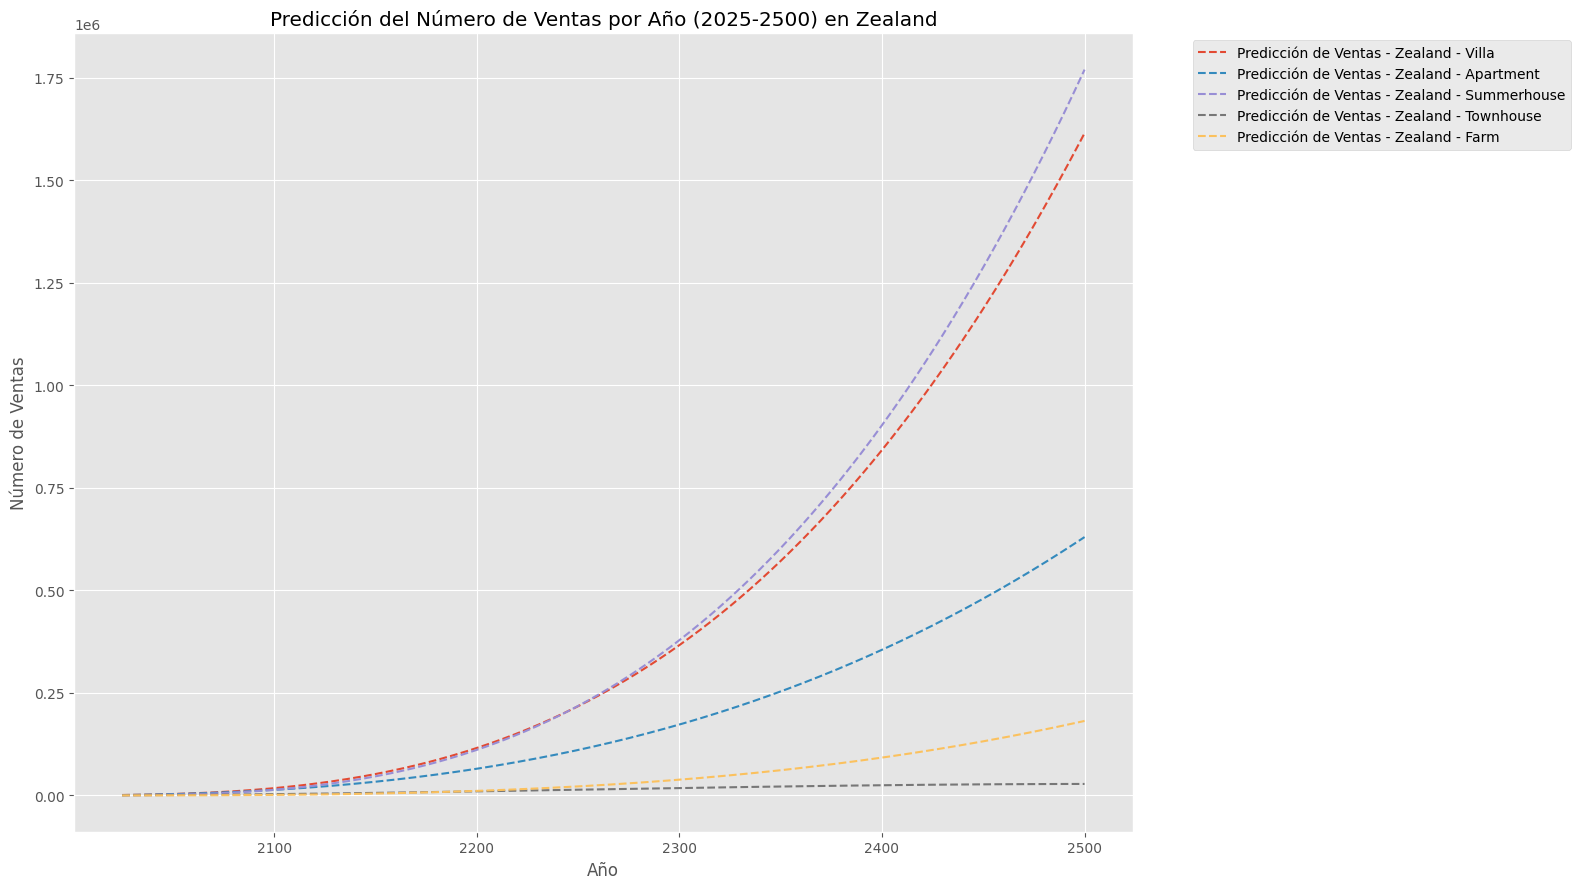

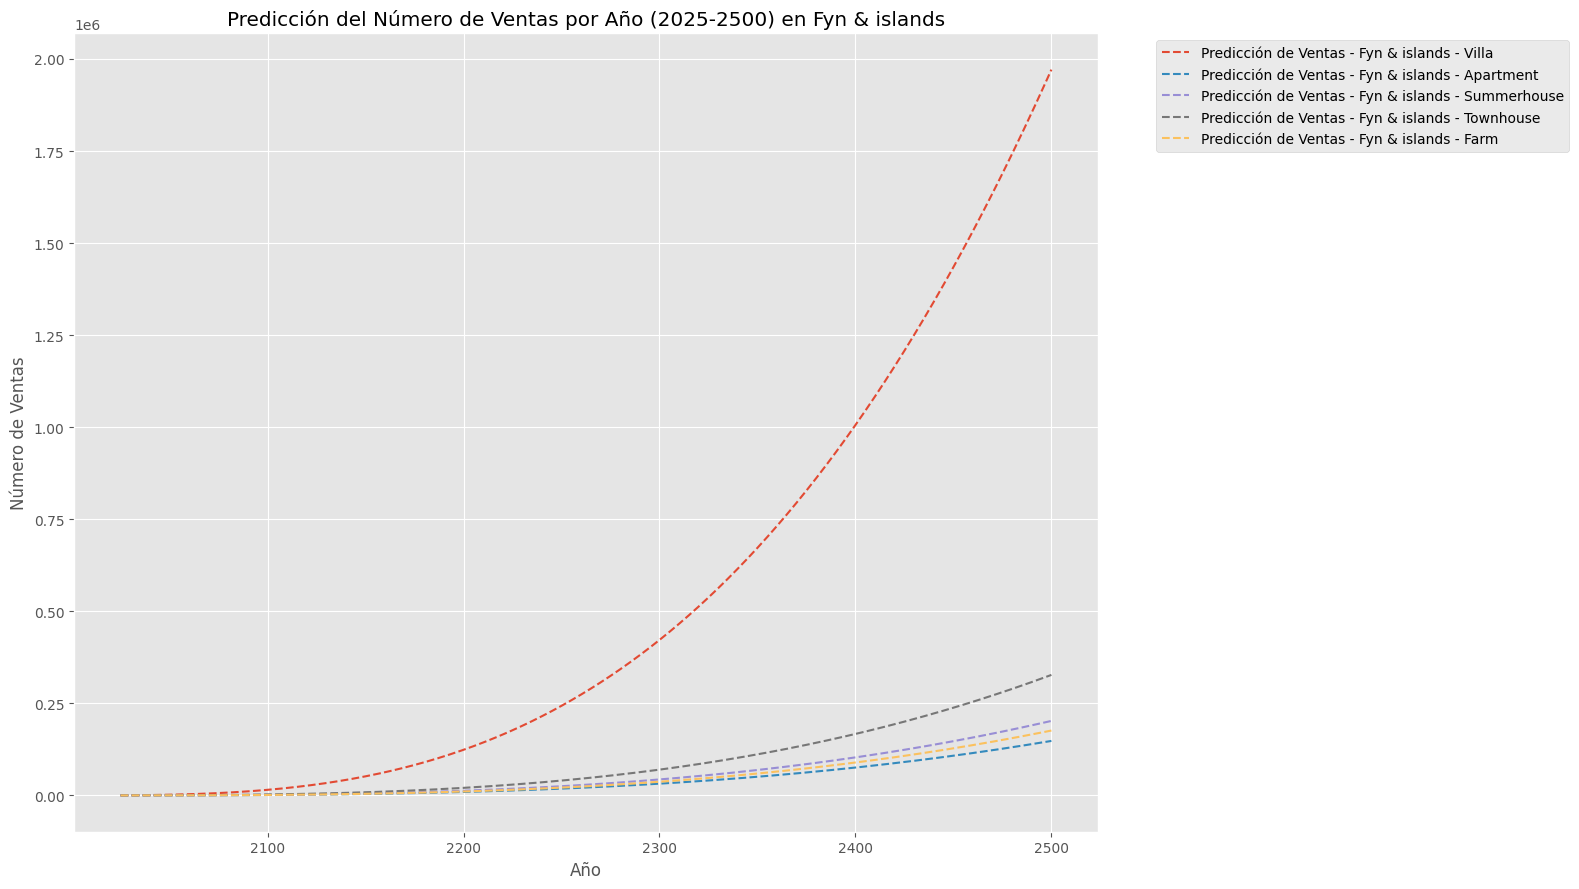

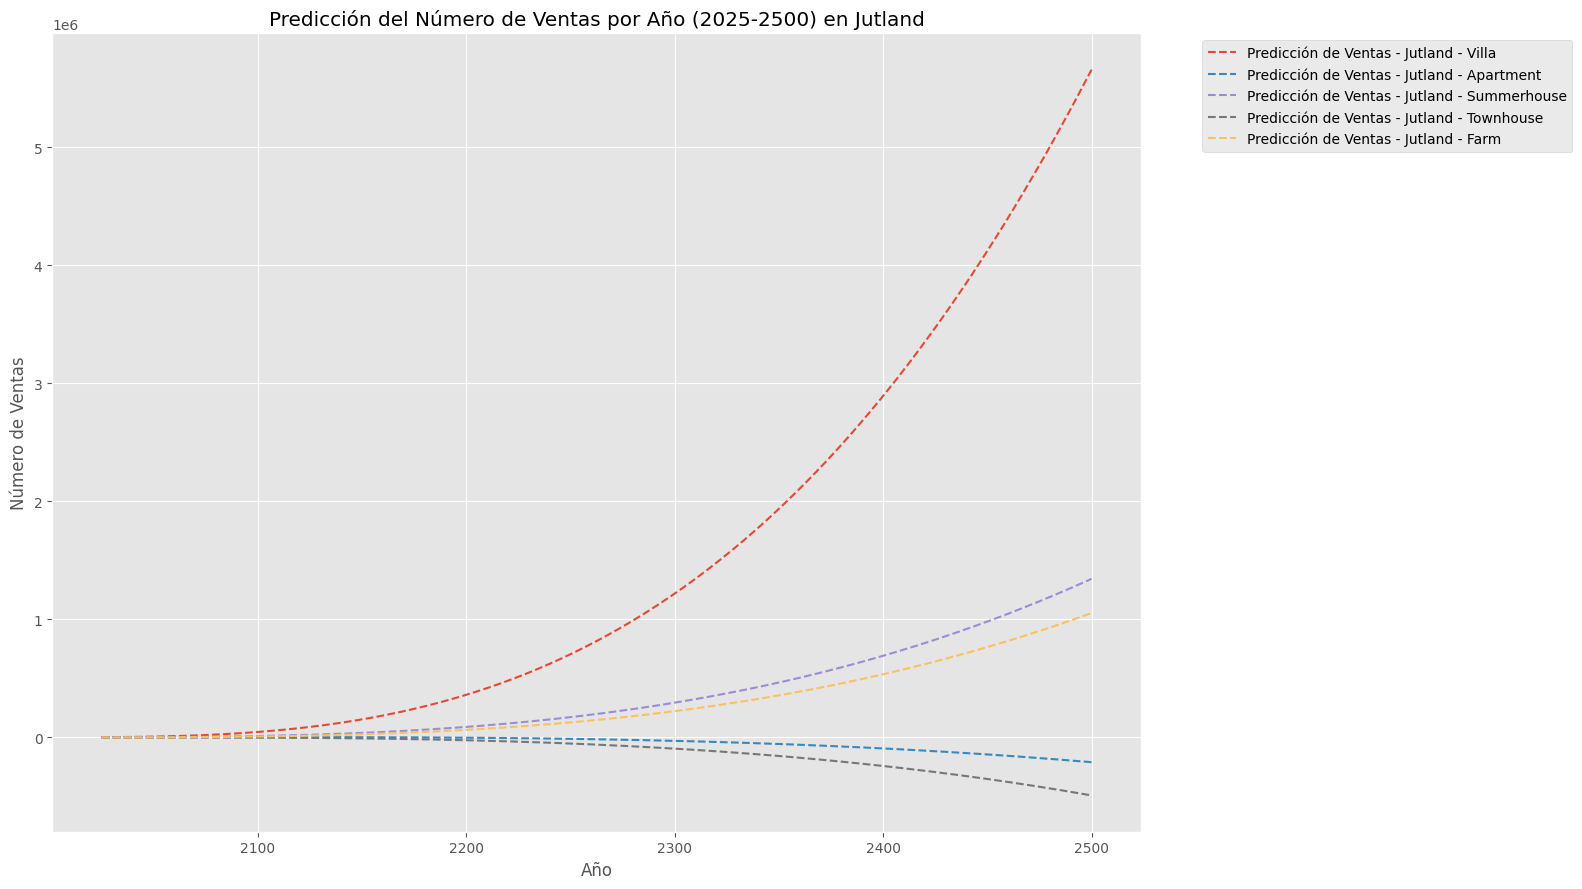

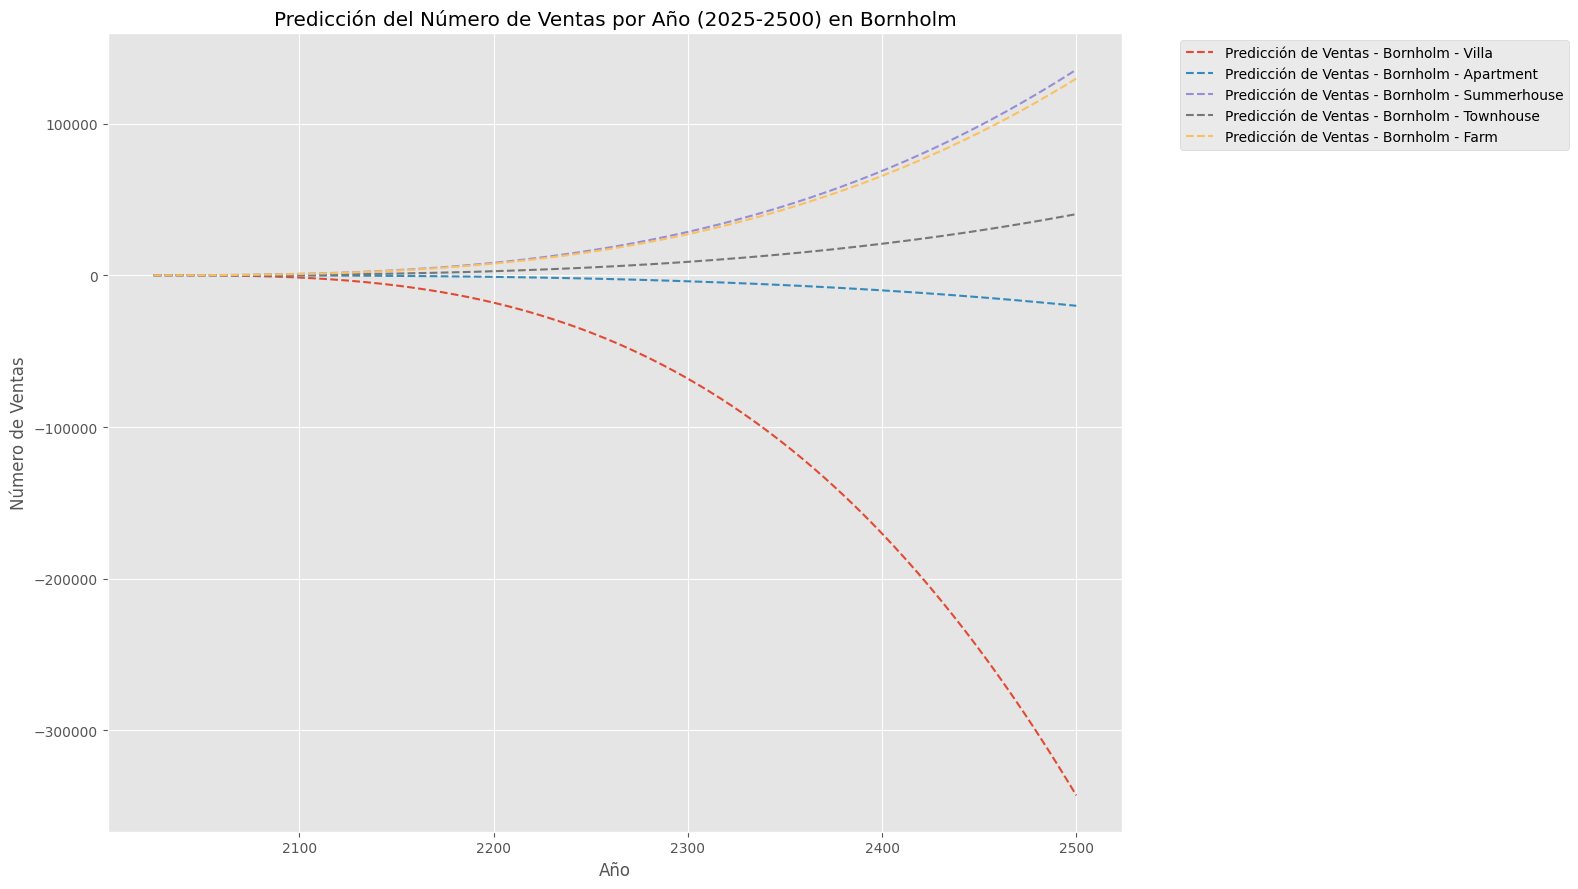

In [34]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

# Crear un diccionario para almacenar las predicciones por región y tipo de casa
predicciones_por_region_tipo = {}

# Obtener las regiones y tipos de casa únicos
regiones = df_houses['region'].unique()
tipos_de_casa = df_houses['house_type'].unique()

# Iterar sobre cada región y tipo de casa
for region in regiones:
    predicciones_por_region_tipo[region] = {}
    for tipo in tipos_de_casa:
        # Filtrar los datos por región y tipo de casa
        region_tipo_data = df_houses[(df_houses['region'] == region) & (df_houses['house_type'] == tipo)].copy()
        
        # Extraer el año de la columna 'date'
        region_tipo_data.loc[:, 'year'] = pd.to_datetime(region_tipo_data['date']).dt.year
        
        # Contar el número de ventas por año
        ventas_por_año = region_tipo_data['year'].value_counts().sort_index()
        
        if not ventas_por_año.empty:
            # Preparar los datos
            X = ventas_por_año.index.values.reshape(-1, 1)
            y = ventas_por_año.values
            
            # Crear y entrenar el modelo con características polinómicas
            pipeline = Pipeline([
                ('poly', PolynomialFeatures(degree=3, include_bias=False)),
                ('scaler', StandardScaler()),
                ('lr', LinearRegression())
            ])
            pipeline.fit(X, y)
            
            # Score del modelo
            score = pipeline.score(X, y)
            print(f"Puntuación para {region} - {tipo}: {score}")
            
            # Predecir el número de ventas de 2025 a 2500
            future_years = np.arange(2025, 2501).reshape(-1, 1)
            future_sales = pipeline.predict(future_years)
            
            # Almacenar las predicciones en el diccionario
            predicciones_por_region_tipo[region][tipo] = (ventas_por_año.index, ventas_por_año.values, future_years, future_sales)

# Graficar las predicciones por región y tipo de casa
for region, tipos in predicciones_por_region_tipo.items():
    plt.figure(figsize=(16, 9))
    for tipo, (historical_years, historical_sales, future_years, future_sales) in tipos.items():
        plt.plot(future_years, future_sales, linestyle='--', label=f'Predicción de Ventas - {region} - {tipo}')
    plt.title(f'Predicción del Número de Ventas por Año (2025-2500) en {region}')
    plt.xlabel('Año')
    plt.ylabel('Número de Ventas')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
